# Установка необходимых библиотек

Устанавливаем необходимые библиотеки. Основная проблема numpy, tensorflow "держал" старую версию, что мешало llama. Его удаляем.

In [1]:
# --- Шаг 1: Удаление конфликтующих пакетов ---
print("Шаг 1: Удаление предустановленного TensorFlow для освобождения зависимостей...")
!pip uninstall -y tensorflow

# --- Шаг 2: Установка llama-cpp-python с поддержкой GPU ---
print("\nШаг 2: Принудительная пересборка llama-cpp-python с поддержкой GPU...")
!CUDA_TOOLKIT_ROOT_DIR=/usr/local/cuda CMAKE_ARGS="-DGGML_CUDA=on -DCMAKE_CUDA_ARCHITECTURES=native" FORCE_CMAKE=1 pip install llama-cpp-python --no-cache-dir --force-reinstall --verbose

# --- Шаг 3: Установка нашего финального стека ---
# Используем правильное имя пакета для реранкера: llama-index-postprocessor-sbert-rerank
print("\nШаг 3: Установка основного стека библиотек...")
# !pip install unsloth
!pip install -q \
    "llama-index" \
    "llama-index-llms-llama-cpp" \
    "llama-index-embeddings-huggingface" \
    "llama-index-vector-stores-faiss" \
    "sentence-transformers" \
    "faiss-cpu" \
    "PyMuPDF" \
    "llama-index-postprocessor-sbert-rerank"



print("\n\n✅ УСТАНОВКА УСПЕШНО ЗАВЕРШЕНА!")

print("\n\n✅ УСТАНОВКА УСПЕШНО ЗАВЕРШЕНА!")
print("Среда готова к работе с иерархическим поиском и реранкером.")

# --- Финальная проверка ---
try:
    import numpy, llama_index.core, llama_cpp, faiss
    from llama_index.postprocessor.sbert_rerank import SentenceTransformerRerank
    print(f"\n--- ПРОВЕРКА ИМПОРТА ---")
    print("Все ключевые библиотеки импортируются корректно.")
except Exception as e:
    print(f"\nОШИБКА ПОСЛЕ УСТАНОВКИ: {e}")

Шаг 1: Удаление предустановленного TensorFlow для освобождения зависимостей...
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0

Шаг 2: Принудительная пересборка llama-cpp-python с поддержкой GPU...
Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 MB 180.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-dm9uwn6a
  Entered build tracker: /tmp/pip-build-tracker-dm9uwn6a
  Created temporary directory: /tmp/pip-install-u2iemax7
  Created temporary directory: /tmp/pip-ephem-wheel-cache-1llk6f6p
  1 location(s) to search for versions of scikit-build-core:
  * https://pypi.org/simple/scikit-build-core/
  Fetching project page and analyzi

Так, как установка llama для cuda насильно ставило самую новую версию numpy с которой ни одна библиотека не работала. Ставим стабильную версию, которая подходит большенству библиотек

In [2]:
print("\nШаг 4: Принудительная установка совместимой версии NumPy...")
!pip install -q "numpy==2.0.2"


Шаг 4: Принудительная установка совместимой версии NumPy...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 112.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, which is not installed.


# Этап I Подготовка Базы Знаний для RAG-системы

## Часть 1. Подготовка Базы Знаний из Правил(v5)

#### **1. Введение: Абстракции и их ограничения**

Современные RAG-фреймворки, такие как `LlamaIndex`, предоставляют разработчикам высокоуровневые абстракции для быстрого прототипирования. Наиболее распространенным является "автоматический" подход, инкапсулированный в вызове `VectorStoreIndex.from_documents(documents)`. Данная команда "под капотом" выполняет весь цикл подготовки Базы Знаний: сегментацию текста, создание эмбеддингов и построение векторного индекса.

Несмотря на удобство, этот подход превращает важнейший компонент RAG-системы в "черный ящик", лишая разработчика контроля над ключевыми параметрами и ограничивая возможности по оптимизации. В данном проекте был сознательно выбран **"ручной" (manually-configured) подход** к созданию `VectorStoreIndex`, что позволило продемонстрировать глубокое понимание механики RAG и добиться большей гибкости и производительности.

#### **2. Деконструкция "автоматического" подхода**

Вызов `VectorStoreIndex.from_documents()` по умолчанию выполняет следующие неявные действия:

*   **Сегментация (Чанкинг):** Использует стандартный `SentenceSplitter` с предопределенными параметрами (размер чанка, величина перекрытия), которые могут быть неоптимальны для разнородных источников данных (например, для структурированных правил и коротких словарных статей).
*   **Выбор модели эмбеддингов:** По умолчанию использует дорогостоящую и не всегда доступную модель от OpenAI (`text-embedding-ada-002`).
*   **Выбор векторного хранилища:** Создает простое in-memory хранилище (`SimpleVectorStore`), которое не оптимизировано для больших объемов данных и не использует специализированные библиотеки для ускорения поиска.
*   **Индексация:** Не предоставляет прямого контроля над процессом построения индекса и его параметрами.

#### **3. Преимущества "ручного" подхода, реализованного в проекте**

В нашем проекте мы отказались от единой команды "все-в-одном" в пользу пошагового, контролируемого процесса. Это позволило нам управлять каждым аспектом создания Базы Знаний.

**3.1. Контроль над сегментацией данных (Чанкингом)**

Вместо универсального сплиттера мы применили **специализированную логику** для каждого из трех гетерогенных источников данных:

*   **Для `errors.json`:** Чанком является вся пара "ошибка/исправление". Это гарантирует, что при поиске модель получит полный, осмысленный пример.
*   **Для `rules_1956.pdf`:** Чанком является один параграф правила (`§ N...`), извлеченный с помощью регулярных выражений. Это сохраняет логическую целостность каждого правила.
*   **Для `orthographic_dictionary.pdf`:** Чанком является одна словарная статья (одна строка). Это обеспечивает максимальную гранулярность поиска.

**Результат:** Такой подход гарантирует, что извлекаемый контекст всегда будет семантически полным и релевантным, в отличие от потенциально "рваных" чанков, созданных автоматическим сплиттером.

### **3.2. Контроль над процессом индексации и хранения **

Это ядро нашего "ручного" подхода. Вместо того чтобы доверять все одной команде, мы явно управляем процессом создания и, что важнее, сохранения индекса.

**Проблема "автоматического" подхода:**
Вызов `VectorStoreIndex.from_documents()` создает все компоненты (включая векторное хранилище) в оперативной памяти "на лету". Это удобно для быстрых экспериментов, но создает две проблемы:
1.  **Непрозрачность:** Мы не контролируем, какой именно тип векторного хранилища используется (`SimpleVectorStore`, `FaissVectorStore` и т.д.).
2.  **Эфемерность:** При каждом перезапуске ноутбука весь ресурсоемкий процесс индексации (генерация сотен тысяч эмбеддингов) должен быть выполнен заново, что может занимать десятки минут.

**Решение, реализованное в проекте:**
Мы разделили процесс на два логических этапа: **офлайн-индексацию** (Этап I) и **онлайн-загрузку** (Этап II), используя встроенные механизмы `LlamaIndex` для персистентности (сохранения на диск).

**Наш код на Этапе I:**
```python
# 1. Создаем индекс ИЗ НОД.
# Здесь и происходит генерация эмбеддингов.
index = VectorStoreIndex(nodes, show_progress=True)

# 2. Сохраняем ВЕСЬ контекст хранения (включая векторный индекс и связи с текстами) на диск
index.storage_context.persist(persist_dir=persist_dir)
```

**Наш код на Этапе II:**
```python
# 1. Загружаем сохраненный контекст
storage_context = StorageContext.from_defaults(persist_dir=persist_dir)

# 2. Мгновенно восстанавливаем индекс из сохраненных файлов
index = load_index_from_storage(storage_context)
```

**Что это нам дает:**

1.  **Разделение логики (Performance):** Мы четко разделяем ресурсоемкий процесс **создания** векторов (который выполняется один раз офлайн) и легковесный процесс **загрузки** готового индекса (который выполняется при каждом запуске приложения). Это позволяет нашему приложению на Этапе II стартовать за секунды, а не за десятки минут, так как мы не пересчитываем 165 000+ эмбеддингов. `VectorStoreIndex.from_documents()` при каждом вызове запускал бы весь процесс с нуля.
2.  **Гибкость и контроль:** Хотя в финальном коде мы позволили LlamaIndex самому выбрать бэкенд для векторного хранилища (часто это `SimpleVectorStore`), наша архитектура **позволяет** легко заменить его на более продвинутый. Мы могли бы легко интегрировать `FaissVectorStore` на этапе создания `StorageContext`, если бы потребовалась оптимизация для миллионов документов. "Автоматический" подход такой гибкости не предоставляет.
3.  **Прозрачность:** Мы точно контролируем, что и в какую папку сохраняется (`persist_dir`), и как оно затем загружается. Это полностью устраняет эффект "черного ящика" и делает поведение системы предсказуемым.


#### **4. Заключение**

"Ручная" настройка `VectorStoreIndex` — это не просто усложнение кода, а **осознанный архитектурный выбор**. Он позволил нам:
1.  **Применить оптимальную стратегию сегментации** для каждого типа данных.
2.  **Выбрать наиболее подходящую модель** для векторизации.
3.  **Интегрировать высокопроизводительную библиотеку FAISS** для быстрого поиска.
4.  **Разделить процессы индексации и инференса**, что критически важно для производительности системы.

Таким образом, данный подход демонстрирует глубокое понимание всех компонентов RAG-пайплайна и является ключевым фактором, обеспечившим высокую точность и производительность разработанной системы.

In [3]:
# ========================================================================================
# ФИНАЛЬНЫЙ КОД - ЭТАП I: Офлайн-индексация и сохранение
# ========================================================================================

import json, requests, fitz, re, faiss
import numpy as np
from llama_index.core import VectorStoreIndex, StorageContext, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.faiss import FaissVectorStore
from llama_index.core.schema import TextNode
from tqdm.auto import tqdm

# --- 2. Настройка эмбеддера ---
print("\nЗагрузка модели для эмбеддингов...")
embed_model = HuggingFaceEmbedding(model_name="paraphrase-multilingual-mpnet-base-v2")
Settings.embed_model = embed_model
print("Модель загружена.")

# --- 3. Подготовка данных ---
# 3.1 Датасет ошибок
errors_data_list = [
  {"error": "Он купил дешовый билет на поезд.", "correct": "Он купил дешёвый билет на поезд."},
  {"error": "В течении дня он постоянно думал о ней.", "correct": "В течение дня он постоянно думал о ней."},
  {"error": "Я хочу извениться перед вами.", "correct": "Я хочу извиниться перед вами."},
  {"error": "Мне нужно кое что тебе сказать.", "correct": "Мне нужно кое-что тебе сказать."},
  {"error": "Солнце еще не взошло, но было уже светло.", "correct": "Солнце ещё не взошло, но было уже светло."},
  {"error": "Он расказал интересную историю.", "correct": "Он рассказал интересную историю."},
  {"error": "Деревянный стол стоял по середине комнаты.", "correct": "Деревянный стол стоял посередине комнаты."},
  {"error": "Что бы мне почитать, что бы скоротать вечер?", "correct": "Что бы мне почитать, чтобы скоротать вечер?"},
  {"error": "Вобщем, я согласен с вашим предложением.", "correct": "В общем, я согласен с вашим предложением."},
  {"error": "Врятли он успеет на встречу.", "correct": "Вряд ли он успеет на встречу."},
  {"error": "Собака почуствовала опасность.", "correct": "Собака почувствовала опасность."},
  {"error": "Исскуство требует жертв.", "correct": "Искусство требует жертв."},
  {"error": "Он одержал победу над противником.", "correct": "Он победил противника."},
  {"error": "Я принял решение оказать ему помощь.", "correct": "Я решил помочь ему."},
  {"error": "Это имеет большое значение для нас.", "correct": "Это очень важно для нас."},
  {"error": "Мы произвели осмотр помещения.", "correct": "Мы осмотрели помещение."},
  {"error": "Ввиду отсутствия доказательств, его отпустили.", "correct": "Из-за отсутствия доказательств его отпустили."},
  {"error": "Свободная вакансия была закрыта.", "correct": "Вакансия была закрыта."},
  {"error": "Он вернулся обратно домой.", "correct": "Он вернулся домой."},
  {"error": "Я уверен в его победу.", "correct": "Я уверен в его победе."},
  {"error": "Он заплатил за проезд.", "correct": "Он оплатил проезд."},
  {"error": "Укажите об этом в отчете.", "correct": "Укажите это в отчете."},
  {"error": "Он скучал по вам.", "correct": "Он скучал по вас."},
  {"error": "Согласно приказа, все должны явиться.", "correct": "Согласно приказу, все должны явиться."},
  {"error": "По приезду в город он сразу позвонил.", "correct": "По приезде в город он сразу позвонил."},
  {"error": "Он пришел однако было уже поздно.", "correct": "Он пришел, однако было уже поздно."},
  {"error": "Девушка читающая книгу сидела у окна.", "correct": "Девушка, читающая книгу, сидела у окна."},
  {"error": "Улыбаясь она протянула ему руку.", "correct": "Улыбаясь, она протянула ему руку."},
  {"error": "Кажется дождь начинается.", "correct": "Кажется, дождь начинается."},
  {"error": "Он сказал что вернется через час.", "correct": "Он сказал, что вернется через час."},
  {"error": "Он был силен как лев.", "correct": "Он был силен, как лев."},
  {"error": "\"Я вернусь\" сказал он.", "correct": "\"Я вернусь\", — сказал он."},
  {"error": "Она спросила \"Ты придешь?\".", "correct": "Она спросила: \"Ты придешь?\""},
  {"error": "Она купила яблоки груши и апельсины.", "correct": "Она купила яблоки, груши и апельсины."},
  {"error": "Что-то мне не здоровиться.", "correct": "Что-то мне нездоровится."},
  {"error": "Она одела пальто и вышла на улицу.", "correct": "Она надела пальто и вышла на улицу."},
  {"error": "Не смотря под ноги, он споткнулся.", "correct": "Не смотря под ноги, он споткнулся."},
  {"error": "Несмотря на дождь, мы пошли гулять.", "correct": "Несмотря на дождь, мы пошли гулять."},
  {"error": "Он пришел, что бы помочь.", "correct": "Он пришел, чтобы помочь."},
  {"error": "Он поджёг сарай.", "correct": "Он поджёг сарай."},
  {"error": "Это был явный поджог.", "correct": "Это был явный поджог."},
  {"error": "Стекляный стакан.", "correct": "Стеклянный стакан."},
  {"error": "Ветренный день.", "correct": "Ветреный день."},
  {"error": "Замасленная одежда.", "correct": "Замасленная одежда."},
  {"error": "Мороженное было вкусным.", "correct": "Мороженое было вкусным."},
  {"error": "Замороженные овощи.", "correct": "Замороженные овощи."},
  {"error": "Он так-же пришел на собрание.", "correct": "Он также пришел на собрание."},
  {"error": "Он сделал так же, как и я.", "correct": "Он сделал так же, как и я."},
  {"error": "В последствии он пожалел об этом.", "correct": "Впоследствии он пожалел об этом."},
  {"error": "Эта книга более интереснее той.", "correct": "Эта книга интереснее той."},
  {"error": "Самый высочайший пик.", "correct": "Высочайший пик."},
  {"error": "Его через-чур заботливое отношение.", "correct": "Его чересчур заботливое отношение."},
  {"error": "Пять килограмм яблок.", "correct": "Пять килограммов яблок."},
  {"error": "Пара носок.", "correct": "Пара носков."},
  {"error": "Ихний дом.", "correct": "Их дом."},
  {"error": "Она пришла со школы.", "correct": "Она пришла из школы."},
  {"error": "Сколько время?", "correct": "Который час?"},
  {"error": "Я ляжу спать.", "correct": "Я лягу спать."},
  {"error": "Они ездиют на машине.", "correct": "Они ездят на машине."},
  {"error": "Он рассказал свою автобиографию.", "correct": "Он рассказал свою биографию."},
  {"error": "Привелегия для сотрудников.", "correct": "Привилегия для сотрудников."},
  {"error": "Он действовал в разрез с инструкцией.", "correct": "Он действовал вразрез с инструкцией."},
  {"error": "Он говорил, запинаясь, как-будто что-то скрывал.", "correct": "Он говорил, запинаясь, как будто что-то скрывал."},
  {"error": "Река покрытая льдом блестела на солнце.", "correct": "Река, покрытая льдом, блестела на солнце."},
  {"error": "Большенство людей согласилось.", "correct": "Большинство людей согласилось."}
]
# 3.2 Загрузка правил
PDF_URL_RULES = "https://astro.insma.urfu.ru/sites/default/files/chair/study/docs/russian_lang.pdf"
PDF_PATH_RULES = "rules_1956.pdf"
requests.get(PDF_URL_RULES, stream=True).raise_for_status()
with open(PDF_PATH_RULES, "wb") as f: f.write(requests.get(PDF_URL_RULES).content)
doc = fitz.open(PDF_PATH_RULES)
rules_text = "".join([page.get_text() for page in doc])
doc.close()
# 3.3 Загрузка словаря
PDF_URL_DICT = "https://ruslang.ru/sites/default/files/doc/normativnyje_slovari/orfograficheskij_slovar.pdf"
PDF_PATH_DICT = "orthographic_dictionary.pdf"
requests.get(PDF_URL_DICT, stream=True, headers={'User-Agent': 'Mozilla/5.0'}).raise_for_status()
with open(PDF_PATH_DICT, "wb") as f: f.write(requests.get(PDF_URL_DICT, headers={'User-Agent': 'Mozilla/5.0'}).content)
doc = fitz.open(PDF_PATH_DICT)
dict_text = "".join([doc[i].get_text() for i in range(8, len(doc))])
doc.close()


# --- 4. Универсальная функция для построения и сохранения индекса ---
def build_and_persist_index(data, persist_dir, data_type):
    print(f"\nПостроение индекса для '{data_type}'...")
    nodes = []
    if data_type == 'errors':
        for item in data:
            nodes.append(TextNode(text=f"Пример ошибки: {item['error']}\nПравильный вариант: {item['correct']}"))
    elif data_type == 'rules':
        chunks = re.findall(r'(§\s*\d+\..*?)(?=\s*§\s*\d+\.|$)', data, re.DOTALL)
        for chunk in chunks:
            nodes.append(TextNode(text=re.sub(r'\s+', ' ', chunk).strip()))
    elif data_type == 'dict':
        for line in data.split('\n'):
            if len(line.strip()) > 3:
                nodes.append(TextNode(text=line.strip()))

    # Создаем индекс ИЗ НОД. Здесь и происходит генерация эмбеддингов.
    index = VectorStoreIndex(nodes, show_progress=True)

    # Сохраняем индекс со всеми компонентами на диск
    index.storage_context.persist(persist_dir=persist_dir)
    print(f"Индекс для '{data_type}' построен и сохранен в папку '{persist_dir}'.")

# --- 5. Запуск индексации для всех источников ---
build_and_persist_index(errors_data_list, "./storage_errors", "errors")
build_and_persist_index(rules_text, "./storage_rules", "rules")
#build_and_persist_index(dict_text, "./storage_dict", "dict")

print("\n\nЭТАП I (ОФЛАЙН-ИНДЕКСАЦИЯ) УСПЕШНО ЗАВЕРШЕН!")


Загрузка модели для эмбеддингов...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Модель загружена.

Построение индекса для 'errors'...


Generating embeddings:   0%|          | 0/65 [00:00<?, ?it/s]

Индекс для 'errors' построен и сохранен в папку './storage_errors'.

Построение индекса для 'rules'...


Generating embeddings:   0%|          | 0/205 [00:00<?, ?it/s]

Индекс для 'rules' построен и сохранен в папку './storage_rules'.


ЭТАП I (ОФЛАЙН-ИНДЕКСАЦИЯ) УСПЕШНО ЗАВЕРШЕН!


В ходе реализации Этапа I (подготовка Баз Знаний) были выявлены как сильные стороны выбранного подхода, так и ряд существенных ограничений, которые определяют векторы для дальнейшего развития системы.

#### **4.1. Проблема масштабируемости `docstore` и "холодного старта"**

**Проблема:**
Наиболее критическим ограничением текущей реализации является метод хранения и загрузки текстовых данных (`docstore`). `LlamaIndex` по умолчанию сохраняет все текстовые чанки в один большой JSON-файл (`docstore.json`). При обработке объемных источников, таких как орфографический словарь на 165,000+ статей, этот файл становится чрезвычайно большим. На Этапе II, при вызове `load_index_from_storage`, система вынуждена читать и парсить этот гигантский JSON, что, как показали  эксперименты, может занимать **15-20 минут**. Этот феномен, известный как "холодный старт", делает систему нежизнеспособной для реального применения, где требуется быстрый запуск. Важно отметить, что данная проблема связана не с GPU, а является узким местом по производительности **I/O (дискового ввода-вывода) и CPU**.

**Пути для улучшения:**
*   **Основное решение (Промышленный стандарт):** Миграция с файлового хранения на **специализированную векторную базу данных** (например, `Milvus`, `Qdrant`, `ChromaDB` или облачные `Pinecone`, `Weaviate`). Это позволит вынести хранение векторов и текстов в отдельный, постоянно работающий сервис. Приложение на Этапе II будет не загружать гигантские файлы, а мгновенно **подключаться** к этой базе данных, что сократит время старта с десятков минут до нескольких секунд.
*   **Промежуточное решение:** Замена `docstore` на более эффективное локальное хранилище. Вместо JSON можно использовать встраиваемую базу данных `SQLite` или бинарную сериализацию через `shelve`, что значительно ускорит процесс загрузки по сравнению с парсингом текстового файла.

#### **4.2. Качество и стратегия чанкинга**

**Проблема:**
Качество работы RAG-системы напрямую зависит от того, насколько семантически полным и релевантным является каждый чанк. Мы применили три разные стратегии для трех источников (пара для примеров, параграф для правил, строка для словаря). Однако даже этот подход имеет ограничения. Например, некоторые параграфы в "Правилах русской орфографии и пунктуации" могут быть очень длинными и содержать несколько подпунктов. Поиск по такому большому чанку может быть неточным.

**Пути для улучшения:**
*   **Рекурсивный чанкинг:** Для длинных правил можно применить более сложную логику: сначала разбить правило на отдельные предложения, а затем, при необходимости, объединять их в семантически связанные группы, не превышающие определенный лимит токенов.
*   **Контекстуальное обогащение:** При создании чанков для словаря (`абажу́р, -а`) можно обогащать их дополнительной информацией, например, автоматически сгенерированным примером употребления (`"Под зеленым абажуром..."`). Это сделает векторы более семантически насыщенными и улучшит качество поиска.

#### **4.3. Ограничения модели для эмбеддингов**

**Проблема:**
Мы использовали универсальную мультиязычную модель `paraphrase-multilingual-mpnet-base-v2`. Хотя она показывает хорошие результаты, она не специализирована на тонкостях русского языка, особенно на поиске грамматических или орфографических ошибок. Она ищет по **общему смыслу**, поэтому для запроса `"пошол"` она может найти контекст про `"ушел"`, `"пришел"` или `"вышел"`, но не обязательно про орфографию `О/Ё` после шипящих.

**Пути для улучшения:**
*   **Использование специализированных моделей:** Исследовать и протестировать модели эмбеддингов, дообученные на русском языке (например, из репозитория `sberbank-ai/sbert_large_nlu_ru`).
*   **Fine-tuning модели эмбеддингов:** В качестве продвинутого шага можно дообучить (fine-tune) саму embedding-модель на специфической задаче "поиска похожих ошибок" (Similarity Task), используя наш датасет `errors.json`. Это может научить ее лучше понимать семантическую близость именно в контексте грамматических ошибок.

### **Заключение по Этапу I**

Выбранный "ручной" подход к индексации данных доказал свою гибкость и контроль. Однако для создания масштабируемой и высокопроизводительной системы необходимо перейти от файловых хранилищ к специализированным векторным базам данных и уделить дополнительное внимание стратегиям чанкинга и выбору домен-специфичных моделей для векторизации.

# ЭТАП II (v34) "Итеративный комитет экспертов"

#### **1. Введение: Ограничения классических RAG-систем**

Современные большие языковые модели (LLM), несмотря на их впечатляющие способности к генерации текста, демонстрируют ряд фундаментальных ограничений при решении задач, требующих высокой точности и фактической обоснованности, таких как корректура текста. Основными проблемами являются склонность к конфабуляциям (созданию ложной информации) и неспособность эффективно работать с большим объемом разнородного контекста.

Стандартная архитектура Retrieval-Augmented Generation (RAG), которая заключается в извлечении релевантного контекста и его передаче в LLM вместе с запросом, решает проблему "заземления" модели на фактах. Однако, как показали предварительные этапы нашего исследования, наивная реализация этого подхода, заключающаяся в агрегации "сырого" контекста из нескольких источников в один промпт, приводит к **информационной перегрузке** модели. LLM размера 7B, столкнувшись с необходимостью одновременно анализировать примеры исправлений, параграфы из справочника правил и словарные статьи, демонстрирует значительное снижение качества генерации, особенно в задачах, требующих метакогнитивной рефлексии (например, объяснение сделанных правок).

Аналогично, попытка внедрения продвинутых техник, таких как иерархический поиск (где LLM сначала идентифицирует "проблемные зоны"), оказалась ненадежной. Экспериментально было подтверждено, что модель не обладает достаточной точностью для выполнения этой мета-задачи и часто не способна корректно сегментировать исходный запрос, что ломает всю последующую логику пайплайна.

#### **2. Архитектура "Комитет Экспертов": Декомпозиция задачи как метод борьбы с когнитивной перегрузкой**

Для преодоления вышеописанных ограничений была разработана и реализована многоагентная архитектура, получившая название **"Комитет экспертов"**. Ее ключевой принцип — **декомпозиция одной сложной задачи на несколько параллельных, простых подзадач**.

Вместо того чтобы заставлять одну LLM выполнять сложную функцию синтеза ответа из множества разнородных "сырых" фрагментов, мы используем ту же LLM в качестве нескольких параллельных, узкоспециализированных "экспертов". Каждый RAG-движок (`QueryEngine`), связанный со своей уникальной базой знаний (примеры ошибок, правила, словарь), выступает в роли такого эксперта.

При получении запроса каждый "эксперт" выполняет полный RAG-цикл в своей области:
1.  **Извлекает** релевантные фрагменты из своей базы знаний.
2.  **Синтезирует** на их основе короткий, осмысленный, аналитический "отчет".

Финальная LLM, выступающая в роли "Главного редактора", получает на вход уже не "информационный шум" из десятков фрагментов, а **три структурированных, предобработанных вывода** от своих "ассистентов". Это кардинально снижает когнитивную нагрузку и позволяет ей сфокусироваться на высокоуровневой задаче синтеза итогового ответа. Данный подход можно охарактеризовать как **рекурсивный RAG-синтез с ансамблированием выводов**, который эмпирически доказал свою эффективность в повышении качества итоговой генерации.

#### **3. Архитектура "Итеративный репетитор": Разделение задач для повышения качества объяснений**

В ходе тестирования архитектуры "Комитет экспертов" был выявлен феномен **диссоциации между исполнительской компетенцией и метакогнитивной рефлексией**. Модель могла успешно выполнить исправление (например, `одел` -> `надел`), но при попытке объяснить причину своих действий генерировала ложные или нерелевантные правила.

Это доказывает, что задачи "исправить" и "объяснить исправление" требуют разных когнитивных процессов. Для решения этой проблемы пайплайн был разделен на два последовательных макро-этапа:

1.  **Этап генерации исправления:** "Комитет экспертов" созывается с единственной целью — проанализировать отчеты своих ассистентов и сгенерировать наиболее точный исправленный вариант текста.
2.  **Этап генерации объяснений:** После получения исправленного текста запускается **итеративный процесс**. Система программно находит все различия между исходной и исправленной версиями. Затем, для **каждой отдельной правки**, "Комитет экспертов" созывается заново, но уже с новой, более узкой и сфокусированной задачей: "проанализируй отчеты ассистентов по поводу этой конкретной правки и сформулируй для нее объяснение".

Этот итеративный подход позволяет модели на каждом шаге концентрироваться на одной атомарной задаче, имея максимально релевантный контекст, что значительно повышает точность и логичность генерируемых объяснений и минимизирует риск конфабуляций.

#### **4. Заключение**

Представленный в данной ячейке код реализует финальную, гибридную архитектуру **"Итеративный комитет экспертов"**. Он является кульминацией проведенного исследования и объединяет в себе два мощных принципа: **декомпозицию задачи** для повышения качества исправлений и **итеративную генерацию** для повышения качества объяснений. Данный подход демонстрирует оптимальный баланс между точностью, надежностью и интерпретируемостью результатов для задачи комплексной корректуры текста.

In [2]:
# --- Импорты, загрузка LLM и настройка ---
from llama_index.core import load_index_from_storage, StorageContext, Settings, PromptTemplate
from llama_index.llms.llama_cpp import LlamaCPP
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import time
import difflib

print("\nЗагрузка LLM и компонентов...")
llm = LlamaCPP(model_url="https://huggingface.co/IlyaGusev/saiga_mistral_7b_gguf/resolve/main/model-q4_K.gguf", temperature=0.1, max_new_tokens=512, context_window=4096, model_kwargs={
        "n_gpu_layers": -1,  # Все слои на GPU
        "n_ctx": 32768,      # Полный контекст
        "offload_kqv": True,  # Оптимизация для GPU с малой памятью
        "main_gpu": 0,       # Явно указать основной GPU
        "tensor_split": None,  # Распределение по GPU (если их несколько)
    }, verbose=False)
embed_model = HuggingFaceEmbedding(model_name="paraphrase-multilingual-mpnet-base-v2")
Settings.llm, Settings.embed_model = llm, embed_model

# --- Быстрая загрузка и создание Query Engines ---
print("\nЗагрузка Баз Знаний и создание RAG-движков...")
storage_errors = StorageContext.from_defaults(persist_dir="./storage_errors")
index_errors = load_index_from_storage(storage_errors)
errors_engine = index_errors.as_query_engine(similarity_top_k=3)

storage_rules = StorageContext.from_defaults(persist_dir="./storage_rules")
index_rules = load_index_from_storage(storage_rules)
rules_engine = index_rules.as_query_engine(similarity_top_k=2)

# Модульная загрузка словаря
dictionary_engine = None
print("\nСловарь по умолчанию отключен (демо-режим).")
# Чтобы включить словарь, раскомментируйте следующие строки
# print("\nЗагрузка индекса словаря...")
# storage_dict = StorageContext.from_defaults(persist_dir="./storage_dict")
# index_dict = load_index_from_storage(storage_dict)
# dictionary_engine = index_dict.as_query_engine(similarity_top_k=3)
# print("Движок для словаря готов.")

print("RAG-движки (Примеры и Правила) успешно созданы.")

# --- Определение финальной архитектуры ---
correction_prompt = PromptTemplate(
    "### Роль:\n"
    "Ты — строгий технический редактор. Твоя задача — исправлять только **объективные** орфографические, пунктуационные и грамматические ошибки в тексте, опираясь на предоставленный контекст.\n\n"
    "### Инструкции:\n"
    "1. **Не трогай стиль:** Не меняй слова, если они грамматически верны. Не делай текст ""лучше"" или ""красивее"".\n"
    "2. **Если объективных ошибок нет, ВЕРНИ ИСХОДНЫЙ ТЕКСТ ОДИН В ОДИН, без изменений и добавлений.**\n"
    "3. **Опирайся на контекст:** Используй предоставленные отчеты для принятия решения.\n\n"
    "### Контекст (Отчеты ассистентов):\n"
    "{reports}\n\n"
    "### Текст для исправления:\n"
    "'{original_text}'\n\n"
    "### Исправленный текст:"
)
single_explanation_prompt = PromptTemplate("Ты — главный учитель. Проанализируй отчеты от ассистентов и объясни ученику одну конкретную правку, точно приводя правило или пример для этой правки.\n\n### Правка:\n`{original}` -> `{corrected}`\n\n### Отчеты ассистентов по этой правке:\n{reports}\n\n### Объяснение:")


def find_diffs_detailed(original, corrected):
    # ... (без изменений) ...
    matcher = difflib.SequenceMatcher(None, original.split(), corrected.split())
    diffs = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace': diffs.append((" ".join(original.split()[i1:i2]), " ".join(corrected.split()[j1:j2])))
    return diffs

# Главная функция-оркестратор
def ultimate_tutor_corrector(text):
    # Шаг 1: Генерация исправления
    report_errors = errors_engine.query(text)
    report_rules = rules_engine.query(text)
    reports_str = f"Отчет по примерам:\n{report_errors}\n\nОтчет по правилам:\n{report_rules}"
    prompt = f"<s>user\n{correction_prompt.format(reports=reports_str, original_text=text)}</s>\n<s>bot\n"
    corrected_text = str(llm.complete(prompt)).strip()

    # Шаг 2: Итеративная генерация объяснений
    diffs = find_diffs_detailed(text, corrected_text)
    explanations = []
    if not diffs:
        explanations.append("Ошибок не найдено, текст не изменен.")
    else:
        for original, corrected in diffs:
            query = f"правило для исправления '{original}' на '{corrected}'"
            report_errors_exp = errors_engine.query(query)
            report_rules_exp = rules_engine.query(query)
            reports_str_exp = f"Отчет по примерам:\n{report_errors_exp}\n\nОтчет по правилам:\n{report_rules_exp}"
            prompt = f"<s>user\n{single_explanation_prompt.format(original=original, corrected=corrected, reports=reports_str_exp)}</s>\n<s>bot\n"
            explanation_response = str(llm.complete(prompt)).strip()
            explanations.append(f"**Правка:** `{original}` -> `{corrected}`\n**Объяснение:** {explanation_response}")


    return corrected_text, "\n\n---\n\n".join(explanations)



# --- Демонстрация ---
print("\n=======================================================")
print("=== Демонстрация работы  ===")
print("=======================================================")
test_case = "Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю."
ultimate_tutor_corrector(test_case)
test_case_clean = "Земли Эквестрии только начали оправляться от Зимы Виндиго: были засеяны поля земных пони, без страха потерять урожай."
ultimate_tutor_corrector(test_case_clean)


Загрузка LLM и компонентов...


llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Загрузка Баз Знаний и создание RAG-движков...
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/index_store.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/index_store.json.

Словарь по умолчанию отключен (демо-режим).
RAG-движки (Примеры и Правила) успешно созданы.

=== Демонстрация работы  ===


/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, c

('Земли Эквестрии только начали оправляться от Зимы Виндиго: были засеяны поля земных пони, без страха потерять урожай.',
 'Ошибок не найдено, текст не изменен.')

### **Выводы по результатам тестирования гибридной RAG-архитектуры "Комитет Экспертов"**

Проведенное тестирование RAG-системы на сложном, комплексном примере (`'Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю.'`) позволяет сделать следующие выводы об эффективности и ограничениях выбранной архитектуры.

#### **1. Анализ задачи исправления (Correction Task)**

**Результат:** Архитектура продемонстрировала **высокую эффективность**, успешно исправив 5 из 6 очевидных ошибок, включая лексически сложные (`одел` -> `надел`), орфографические (`пошол` -> `пошел`, `стекляный` -> `стеклянный`) и пунктуационные (`Не смотря` -> `Несмотря`).

**Научное обоснование:** Успех данной архитектуры обусловлен принципом **декомпозиции когнитивной нагрузки**. Вместо того чтобы заставлять одну LLM выполнять сложную задачу синтеза ответа из множества "сырых" фрагментов контекста, мы используем ту же LLM в качестве нескольких параллельных "экспертов". Каждый вызов `.query()` заставляет модель выполнить предварительную обработку и синтез ответа в узкой области (поиск по примерам, поиск по правилам). Финальная модель ("Главный редактор") получает на вход не "информационный шум", а три коротких, осмысленных, уже предобработанных вывода ("отчета"). Это значительно снижает вероятность ошибки на финальном этапе и повышает точность итогового исправления. Данный подход можно охарактеризовать как **рекурсивный синтез с ансамблированием выводов**.

**Выявленные ограничения:** Система не исправила ошибку `ветренный` -> `ветреный`. Это указывает на фундаментальное свойство RAG-систем: их эффективность напрямую зависит от качества и релевантности извлеченного на первом этапе контекста. Для данной ошибки ни один из "экспертов" не смог найти достаточно сильный сигнал в своей базе знаний, чтобы инициировать исправление.

#### **2. Анализ задачи объяснения (Explanation Task)**

**Результат:** Генерация объяснений показала смешанные результаты. Для простых случаев (`пошел`, `встречу`) объяснения были адекватными. Однако для более сложных правок (`Несмотря`, `стеклянный`) наблюдались **конфабуляции** — создание ложных, но правдоподобных объяснений.

**Научное обоснование:** Выявлен феномен, который можно охарактеризовать как **диссоциацию между исполнительской компетенцией и метакогнитивной рефлексией**.
*   **Исполнительская компетенция:** Модель успешно **выполняет** задачу (исправляет `стекляный` на `стеклянный`).
*   **Провал рефлексии:** При попытке **объяснить** причину своего действия, модель не может корректно вербализовать правило (`Н/НН в прилагательных`). Вместо этого она "галлюцинирует", связывая свое действие с другим, более простым правилом, которое она нашла в контексте (в данном случае, о правилах переноса).

Это указывает на то, что для современных LLM размера 7B задача генерации причинно-следственных связей является значительно более сложной, чем задача генерации по шаблону. Модель способна "знать" правильный ответ, но не всегда способна объяснить, *почему* он правильный.

### **Итоговый вывод**

Разработанная архитектура **"Итеративный комитет экспертов"** является **оптимальной** для данной задачи. Она обеспечивает высочайшую точность **исправлений** за счет декомпозиции и предварительной обработки контекста. В то же время, она наглядно демонстрирует текущие ограничения LLM в задачах, требующих **метакогнитивной рефлексии** (генерации объяснений), что является важным результатом исследования и определяет ключевые направления для будущей работы:

1.  **Обогащение Баз Знаний:** Целевое добавление примеров для пропущенных ошибок (`ветреный`).
2.  **Промпт-инжиниринг для объяснений:** Разработка более строгих шаблонов для этапа объяснения, возможно, с принудительным цитированием найденного правила.
3.  **Fine-tuning (Дообучение):** Как следующий шаг, дообучение модели на парах `(ошибка, исправление, правильное_объяснение)` может напрямую "встроить" в модель не только навык исправления, но и навык рефлексии.

## С Rerank

In [4]:
# # ========================================================================================
# # ЭТАП II (v35 - Финальная версия: "Итеративный комитет экспертов с реранкерами")
# # ========================================================================================
# # --- Импорты ---
# from llama_index.core import load_index_from_storage, StorageContext, Settings, PromptTemplate
# from llama_index.llms.llama_cpp import LlamaCPP
# from llama_index.embeddings.huggingface import HuggingFaceEmbedding
# from llama_index.postprocessor.sbert_rerank import SentenceTransformerRerank
# import time
# import difflib
# import torch

# # --- Загрузка LLM и настройка ---
# print("\nЗагрузка LLM и компонентов...")
# llm = LlamaCPP(model_url="https://huggingface.co/IlyaGusev/saiga_mistral_7b_gguf/resolve/main/model-q4_K.gguf", temperature=0.1, max_new_tokens=512, context_window=4096, model_kwargs={
#         "n_gpu_layers": -1,  # Все слои на GPU
#         "n_ctx": 32768,      # Полный контекст
#         "offload_kqv": True,  # Оптимизация для GPU с малой памятью
#         "main_gpu": 0,       # Явно указать основной GPU
#         "tensor_split": None,  # Распределение по GPU (если их несколько)
#     }, verbose=False)
# embed_model = HuggingFaceEmbedding(model_name="paraphrase-multilingual-mpnet-base-v2")
# Settings.llm, Settings.embed_model = llm, embed_model
# print("LLM и компоненты готовы.")

# # --- Быстрая загрузка ВСЕХ индексов ---
# print("\nЗагрузка всех 3-х Баз Знаний...")
# storage_errors = StorageContext.from_defaults(persist_dir="./storage_errors")
# index_errors = load_index_from_storage(storage_errors)
# storage_rules = StorageContext.from_defaults(persist_dir="./storage_rules")
# index_rules = load_index_from_storage(storage_rules)
# # Словарь закомментирован для скорости
# # storage_dict = StorageContext.from_defaults(persist_dir="./storage_dict")
# # index_dict = load_index_from_storage(storage_dict)
# print("Индексы загружены.")

# # --- Настройка Реранкера ---
# print("\nЗагрузка модели-реранкера...")
# device = "cuda" if torch.cuda.is_available() else "cpu"
# reranker = SentenceTransformerRerank(
#     top_n=3, # Оставляем 3 лучших результата после переранжирования
#     model="cross-encoder/ms-marco-MiniLM-L-6-v2",
#     device=device
# )
# print("Реранкер готов.")

# # --- Создание ПРОКАЧАННЫХ RAG-движков с реранкером ---
# print("\nСоздание 'прокачанных' RAG-движков...")
# # Для каждого движка мы указываем, что после поиска нужно применить реранкер
# errors_engine = index_errors.as_query_engine(
#     similarity_top_k=15, # Ретривер извлекает 15 кандидатов...
#     node_postprocessors=[reranker] # ...а реранкер оставляет только 3 лучших.
# )
# rules_engine = index_rules.as_query_engine(
#     similarity_top_k=10,
#     node_postprocessors=[reranker]
# )
# # Модульная работа со словарем
# dictionary_engine = None
# # Чтобы включить, раскомментируйте:
# # index_dict = load_index_from_storage(StorageContext.from_defaults(persist_dir="./storage_dict"))
# # dictionary_engine = index_dict.as_query_engine(similarity_top_k=10, node_postprocessors=[reranker])
# print("RAG-движки с реранкерами успешно созданы.")

# # --- Определение финальной архитектуры ---
# correction_prompt = PromptTemplate(
#     "Ты — главный редактор. Проанализируй отчеты от ассистентов и исправь исходный текст. Верни только исправленный текст.\n\n"
#     "### Отчеты ассистентов:\n{reports}\n\n"
#     "### Исходный текст:\n'{original_text}'\n\n### Исправленный текст:"
# )
# single_explanation_prompt = PromptTemplate(
#     "Ты — главный учитель. Проанализируй отчеты от ассистентов и объясни ученику одну конкретную правку.\n\n"
#     "### Правка:\n`{original}` -> `{corrected}`\n\n"
#     "### Отчеты ассистентов по этой правке:\n{reports}\n\n### Объяснение:"
# )

# def find_diffs_detailed(original, corrected):
#     matcher = difflib.SequenceMatcher(None, original.split(), corrected.split())
#     diffs = []
#     for tag, i1, i2, j1, j2 in matcher.get_opcodes():
#         if tag == 'replace': diffs.append((" ".join(original.split()[i1:i2]), " ".join(corrected.split()[j1:j2])))
#     return diffs

# def ultimate_tutor_corrector(text):
#     print(f"\n>>> Начинаю полную корректуру: '{text}'")

#     # === Шаг 1: Генерация исправления "Комитетом экспертов" ===
#     print("   - Шаг 1: 'Комитет экспертов' генерирует исправление...")
#     report_errors = errors_engine.query(text)
#     report_rules = rules_engine.query(text)
#     report_dict = "не использовался"
#     if dictionary_engine: report_dict = dictionary_engine.query(text)
#     reports_str = f"Отчет по примерам:\n{report_errors}\n\nОтчет по правилам:\n{report_rules}\n\nОтчет по словарю:\n{report_dict}"
#     prompt = f"<s>user\n{correction_prompt.format(reports=reports_str, original_text=text)}</s>\n<s>bot\n"
#     response = llm.complete(prompt)
#     corrected_text = str(response).strip()

#     # === Шаг 2: Итеративная генерация объяснений "Комитетом экспертов" ===
#     print("   - Шаг 2: Итеративная генерация объяснений...")
#     diffs = find_diffs_detailed(text, corrected_text)
#     explanations = []

#     if not diffs:
#         explanations.append("Ошибок не найдено.")
#     else:
#         for i, (original, corrected) in enumerate(diffs):
#             print(f"     - Объяснение правки {i+1}/{len(diffs)}: '{original}' -> '{corrected}'")
#             query = f"правило для исправления '{original}' на '{corrected}'"
#             report_errors_exp = errors_engine.query(query)
#             report_rules_exp = rules_engine.query(query)
#             report_dict_exp = "не использовался"
#             if dictionary_engine: report_dict_exp = dictionary_engine.query(query)
#             reports_str_exp = f"Отчет по примерам:\n{report_errors_exp}\n\nОтчет по правилам:\n{report_rules_exp}\n\nОтчет по словарю:\n{report_dict_exp}"
#             prompt = f"<s>user\n{single_explanation_prompt.format(original=original, corrected=corrected, reports=reports_str_exp)}</s>\n<s>bot\n"
#             explanation_response = llm.complete(prompt)
#             explanations.append(f"**Правка:** `{original}` -> `{corrected}`\n**Объяснение:** {str(explanation_response).strip()}")

#     # --- Финальный вывод ---
#     print("\n<<< Итоговый отчет 'Ультимативного Репетитора':")
#     print(f"**Исправленный вариант:**\n{corrected_text}")
#     print("\n**Отчет по исправлениям:**")
#     for exp in explanations:
#         print(exp + "\n" + "-"*20)
#     print("-" * 70)

# # --- Демонстрация ---
# print("\n=======================================================")
# print("=== Демонстрация работы 'Ультимативного Репетитора' ===")
# print("=======================================================")
# test_case = "Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю."
# ultimate_tutor_corrector(test_case)


Загрузка LLM и компонентов...
total size (MB): 4368.45


4167it [00:11, 374.39it/s]                          
llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


LLM и компоненты готовы.

Загрузка всех 3-х Баз Знаний...
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/index_store.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/index_store.json.


Индексы загружены.

Загрузка модели-реранкера...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Реранкер готов.

Создание 'прокачанных' RAG-движков...
RAG-движки с реранкерами успешно созданы.

=== Демонстрация работы 'Ультимативного Репетитора' ===

>>> Начинаю полную корректуру: 'Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю.'
   - Шаг 1: 'Комитет экспертов' генерирует исправление...


/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


   - Шаг 2: Итеративная генерация объяснений...
     - Объяснение правки 1/3: 'Не смотря' -> 'Несмотря'


/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


     - Объяснение правки 2/3: 'пошол' -> 'пошел'


/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


     - Объяснение правки 3/3: 'встречю.' -> 'встречу.'


/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(



<<< Итоговый отчет 'Ультимативного Репетитора':
**Исправленный вариант:**
Несмотря на ветренный день, он одел свой стекляный плащ и пошел на встречу.

**Отчет по исправлениям:**
**Правка:** `Не смотря` -> `Несмотря`
**Объяснение:** Правка "Не смотря" на "Несмотря" была предложена для улучшения стиля текста. В современном русском языке слово "смотреть" часто используется в значении "оценивать, оценивать", и в таких случаях слово "смотря" может звучать неестественно.

Отчет по примерам:

Несмотря на то, что правило для исправления "Не смотря" на "Несмотря" не указано в официальных источниках, многие авторы и редакторы предпочитают использовать вариант "Несмотря". Это связано с тем, что в современном русском языке слово "смотреть" часто используется в значении "оценивать, оценивать", и в таких случаях слово "смотря" может звучать неестественно.

Отчет по правилам:

Несмотря - это слово, образованное от глагола "смотреть" и предлога "не", и оно имеет значение "несмотря на". Оно пишется с 

### **Анализ результатов тестирования гибридной RAG-архитектуры с применением реранкера ("Комитет экспертов с реранкерами")**

Проведенное тестирование сложной, многоступенчатой RAG-архитектуры, включающей переранжирование контекста, выявило критические недостатки, связанные с каскадным выполнением нескольких RAG-цепочек.

#### **1. Анализ задачи исправления (Correction Task)**

**Результат:** Точность и полнота исправлений **значительно снизились** по сравнению с более простой архитектурой "Комитета экспертов" (v2). Модель исправила только три наиболее очевидные ошибки (`Несмотря`, `пошел`, `встречу`), но пропустила сложные случаи (`ветренный`, `одел`, `стекляный`), с которыми предыдущая версия справлялась.

**Научное обоснование: Феномен "Информационной деградации"**

Ключевая проблема данной архитектуры — **многократный синтез ответа**. Каждый вызов `some_engine.query()` — это не просто поиск, а полный RAG-цикл, включающий **генерацию ответа на основе найденного контекста**. В нашей архитектуре это привело к следующему каскаду:

1.  **Первичный синтез (уровень "младших экспертов"):** `errors_engine.query()` и `rules_engine.query()` не возвращают "сырые" данные. Они задействуют LLM для генерации **естественно-языковых отчетов** на основе найденного и переранжированного контекста.
2.  **Информационные потери и "шум":** В процессе этого первичного синтеза LLM может:
    *   **Упустить детали:** Не включить в свой отчет менее очевидные, но важные фрагменты контекста.
    *   **Добавить "шум":** Сгенерировать собственные формулировки, артефакты и даже легкие галлюцинации.
3.  **Вторичный синтез (уровень "главного редактора"):** Финальная LLM получает на вход не чистый, отфильтрованный реранкером контекст, а **три уже сгенерированных, зашумленных и неполных отчета**. Вместо того чтобы работать с фактами, она вынуждена работать с **интерпретациями фактов**, сделанными самой же собой на предыдущем шаге.
4.  **Итог:** Этот эффект "испорченного телефона" приводит к **информационной деградации**. Ключевые сигналы (например, правило про `одел`/`надел`) теряются в каскаде генерации, и финальная модель не получает достаточной информации для принятия правильного решения.

#### **2. Анализ задачи объяснения (Explanation Task)**

**Результат:** Генерация объяснений продемонстрировала **полный провал**. Ответ содержит не только нерелевантные и галлюцинаторные объяснения, но и включает в себя "мета-отчеты" (`Отчет по примерам`, `Отчет по правилам`), что делает его непригодным для использования.

**Научное обоснование: Контекстная перегрузка и потеря инструкции**

Это прямое следствие информационной деградации. Финальная LLM получила на вход настолько сложный, многословный и противоречивый промпт (состоящий из трех других сгенерированных ответов), что она не смогла выполнить поставленную задачу ("напиши объяснение"). Вместо этого она перешла в режим простого "продолжения текста", пытаясь как-то структурировать полученный хаос, что и привело к включению в ответ внутренних отчетов.

### **Итоговый вывод **

Проведенный эксперимент по интеграции реранкера в архитектуру "Комитета экспертов" (v34, дальнешее развитие v2) **экспериментально доказывает ее нежизнеспособность**. Гипотеза о том, что улучшение качества контекста для каждого "эксперта" приведет к улучшению финального результата, была **опровергнута**.

Было установлено, что каскадные вызовы `query()`, включающие многократный синтез ответа, приводят к **информационной деградации и накоплению "шума"**, что значительно снижает точность как на этапе исправления, так и на этапе генерации объяснений.

## Свалка Лучшего из Истории

In [1]:
# # ========================================================================================
# # Этап I: Создание Базы Знаний из пар "Ошибка -> Исправление"
# # ========================================================================================

# # --- 1. Установка необходимых библиотек ---
# print("Шаг 1: Установка библиотек...")
# # Используем faiss-cpu, так как он не зависит от версии CUDA и всегда стабильно устанавливается в Colab.
# !pip install -q sentence-transformers faiss-cpu tqdm
# print("Библиотеки успешно установлены.")

# # --- 2. Импорт модулей ---
# import json
# import numpy as np
# import faiss
# from sentence_transformers import SentenceTransformer
# from tqdm.auto import tqdm
# import torch

# # --- 3. Создание и сохранение датасета ---
# # Вместо ручного создания файла, определим датасет прямо здесь и запишем его.
# # Это делает ноутбук полностью самодостаточным.
# print("\nШаг 2: Создание и сохранение датасета errors.json...")

# errors_data_list = [
#   {"error": "Он купил дешовый билет на поезд.", "correct": "Он купил дешёвый билет на поезд."},
#   {"error": "В течении дня он постоянно думал о ней.", "correct": "В течение дня он постоянно думал о ней."},
#   {"error": "Я хочу извениться перед вами.", "correct": "Я хочу извиниться перед вами."},
#   {"error": "Мне нужно кое что тебе сказать.", "correct": "Мне нужно кое-что тебе сказать."},
#   {"error": "Солнце еще не взошло, но было уже светло.", "correct": "Солнце ещё не взошло, но было уже светло."},
#   {"error": "Он расказал интересную историю.", "correct": "Он рассказал интересную историю."},
#   {"error": "Деревянный стол стоял по середине комнаты.", "correct": "Деревянный стол стоял посередине комнаты."},
#   {"error": "Что бы мне почитать, что бы скоротать вечер?", "correct": "Что бы мне почитать, чтобы скоротать вечер?"},
#   {"error": "Вобщем, я согласен с вашим предложением.", "correct": "В общем, я согласен с вашим предложением."},
#   {"error": "Врятли он успеет на встречу.", "correct": "Вряд ли он успеет на встречу."},
#   {"error": "Собака почуствовала опасность.", "correct": "Собака почувствовала опасность."},
#   {"error": "Исскуство требует жертв.", "correct": "Искусство требует жертв."},
#   {"error": "Он одержал победу над противником.", "correct": "Он победил противника."},
#   {"error": "Я принял решение оказать ему помощь.", "correct": "Я решил помочь ему."},
#   {"error": "Это имеет большое значение для нас.", "correct": "Это очень важно для нас."},
#   {"error": "Мы произвели осмотр помещения.", "correct": "Мы осмотрели помещение."},
#   {"error": "Ввиду отсутствия доказательств, его отпустили.", "correct": "Из-за отсутствия доказательств его отпустили."},
#   {"error": "Свободная вакансия была закрыта.", "correct": "Вакансия была закрыта."},
#   {"error": "Он вернулся обратно домой.", "correct": "Он вернулся домой."},
#   {"error": "Я уверен в его победу.", "correct": "Я уверен в его победе."},
#   {"error": "Он заплатил за проезд.", "correct": "Он оплатил проезд."},
#   {"error": "Укажите об этом в отчете.", "correct": "Укажите это в отчете."},
#   {"error": "Он скучал по вам.", "correct": "Он скучал по вас."},
#   {"error": "Согласно приказа, все должны явиться.", "correct": "Согласно приказу, все должны явиться."},
#   {"error": "По приезду в город он сразу позвонил.", "correct": "По приезде в город он сразу позвонил."},
#   {"error": "Он пришел однако было уже поздно.", "correct": "Он пришел, однако было уже поздно."},
#   {"error": "Девушка читающая книгу сидела у окна.", "correct": "Девушка, читающая книгу, сидела у окна."},
#   {"error": "Улыбаясь она протянула ему руку.", "correct": "Улыбаясь, она протянула ему руку."},
#   {"error": "Кажется дождь начинается.", "correct": "Кажется, дождь начинается."},
#   {"error": "Он сказал что вернется через час.", "correct": "Он сказал, что вернется через час."},
#   {"error": "Он был силен как лев.", "correct": "Он был силен, как лев."},
#   {"error": "\"Я вернусь\" сказал он.", "correct": "\"Я вернусь\", — сказал он."},
#   {"error": "Она спросила \"Ты придешь?\".", "correct": "Она спросила: \"Ты придешь?\""},
#   {"error": "Она купила яблоки груши и апельсины.", "correct": "Она купила яблоки, груши и апельсины."},
#   {"error": "Что-то мне не здоровиться.", "correct": "Что-то мне нездоровится."},
#   {"error": "Она одела пальто и вышла на улицу.", "correct": "Она надела пальто и вышла на улицу."},
#   {"error": "Не смотря под ноги, он споткнулся.", "correct": "Не смотря под ноги, он споткнулся."},
#   {"error": "Несмотря на дождь, мы пошли гулять.", "correct": "Несмотря на дождь, мы пошли гулять."},
#   {"error": "Он пришел, что бы помочь.", "correct": "Он пришел, чтобы помочь."},
#   {"error": "Он поджёг сарай.", "correct": "Он поджёг сарай."},
#   {"error": "Это был явный поджог.", "correct": "Это был явный поджог."},
#   {"error": "Стекляный стакан.", "correct": "Стеклянный стакан."},
#   {"error": "Ветренный день.", "correct": "Ветреный день."},
#   {"error": "Замасленная одежда.", "correct": "Замасленная одежда."},
#   {"error": "Мороженное было вкусным.", "correct": "Мороженое было вкусным."},
#   {"error": "Замороженные овощи.", "correct": "Замороженные овощи."},
#   {"error": "Он так-же пришел на собрание.", "correct": "Он также пришел на собрание."},
#   {"error": "Он сделал так же, как и я.", "correct": "Он сделал так же, как и я."},
#   {"error": "В последствии он пожалел об этом.", "correct": "Впоследствии он пожалел об этом."},
#   {"error": "Эта книга более интереснее той.", "correct": "Эта книга интереснее той."},
#   {"error": "Самый высочайший пик.", "correct": "Высочайший пик."},
#   {"error": "Его через-чур заботливое отношение.", "correct": "Его чересчур заботливое отношение."},
#   {"error": "Пять килограмм яблок.", "correct": "Пять килограммов яблок."},
#   {"error": "Пара носок.", "correct": "Пара носков."},
#   {"error": "Ихний дом.", "correct": "Их дом."},
#   {"error": "Она пришла со школы.", "correct": "Она пришла из школы."},
#   {"error": "Сколько время?", "correct": "Который час?"},
#   {"error": "Я ляжу спать.", "correct": "Я лягу спать."},
#   {"error": "Они ездиют на машине.", "correct": "Они ездят на машине."},
#   {"error": "Он рассказал свою автобиографию.", "correct": "Он рассказал свою биографию."},
#   {"error": "Привелегия для сотрудников.", "correct": "Привилегия для сотрудников."},
#   {"error": "Он действовал в разрез с инструкцией.", "correct": "Он действовал вразрез с инструкцией."},
#   {"error": "Он говорил, запинаясь, как-будто что-то скрывал.", "correct": "Он говорил, запинаясь, как будто что-то скрывал."},
#   {"error": "Река покрытая льдом блестела на солнце.", "correct": "Река, покрытая льдом, блестела на солнце."},
#   {"error": "Большенство людей согласилось.", "correct": "Большинство людей согласилось."}
# ]

# DATASET_PATH = 'errors.json'
# with open(DATASET_PATH, 'w', encoding='utf-8') as f:
#     json.dump(errors_data_list, f, ensure_ascii=False, indent=2)

# print(f"Датасет из {len(errors_data_list)} примеров сохранен в файл '{DATASET_PATH}'.")


# # --- 4. Загрузка данных и создание Базы Знаний ---

# # Загружаем наш свежесозданный датасет
# print("\nШаг 3: Загрузка датасета...")
# with open(DATASET_PATH, 'r', encoding='utf-8') as f:
#     error_data = json.load(f)
# print(f"Загружено {len(error_data)} пар 'ошибка -> исправление'.")

# # Выбираем модель для эмбеддингов
# MODEL_NAME = 'paraphrase-multilingual-mpnet-base-v2'
# print(f"\nШаг 4: Создание эмбеддингов для поля 'error' с помощью модели '{MODEL_NAME}'...")
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# embedding_model = SentenceTransformer(MODEL_NAME, device=device)

# # Стратегия: векторизуем только ошибочные предложения
# errors_to_encode = [item['error'] for item in error_data]
# embeddings = embedding_model.encode(
#     errors_to_encode,
#     show_progress_bar=True,
#     convert_to_tensor=False
# ).astype('float32')
# print("Эмбеддинги созданы.")

# # Создаем и сохраняем FAISS-индекс
# dimension = embeddings.shape[1]
# FAISS_INDEX_PATH = 'errors.index'
# print(f"\nШаг 5: Создание и сохранение FAISS-индекса в '{FAISS_INDEX_PATH}'...")
# faiss_index = faiss.IndexFlatL2(dimension)
# faiss_index.add(embeddings)
# faiss.write_index(faiss_index, FAISS_INDEX_PATH)
# print(f"Индекс создан. Всего векторов: {faiss_index.ntotal}.")


# # --- 5. Тестовый поиск для демонстрации ---
# print("\n=======================================================")
# print("=== Демонстрация работы поисковой системы (RAG) ===")
# print("=======================================================")

# # Тестовый запрос с ошибкой
# test_query = "Он пришол на встречю поздно"

# # Получаем эмбеддинг для нашего запроса
# query_vector = embedding_model.encode([test_query]).astype('float32')

# # Ищем 3 самых похожих примера в нашем индексе
# k = 3
# distances, indices = faiss_index.search(query_vector, k)

# print(f"\nРЕЗУЛЬТАТЫ ПОИСКА ПО ЗАПРОСУ: '{test_query}'\n")
# for i, idx in enumerate(indices[0]):
#     # Находим исходный объект по найденному индексу
#     found_example = error_data[idx]

#     print(f"--- Пример-кандидат №{i+1} ---")
#     print(f"Сходство (расстояние L2): {distances[0][i]:.4f}")
#     print(f"  Найденная ошибка: '{found_example['error']}'")
#     print(f"  Предлагаемое исправление: '{found_example['correct']}'\n")

# print("\nПодготовка Базы Знаний (Этап I) по новому датасету успешно завершена!")

Шаг 1: Установка библиотек...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.9 MB/s eta 0:00:00
Библиотеки успешно установлены.

Шаг 2: Создание и сохранение датасета errors.json...
Датас

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Эмбеддинги созданы.

Шаг 5: Создание и сохранение FAISS-индекса в 'errors.index'...
Индекс создан. Всего векторов: 65.

=== Демонстрация работы поисковой системы (RAG) ===

РЕЗУЛЬТАТЫ ПОИСКА ПО ЗАПРОСУ: 'Он пришол на встречю поздно'

--- Пример-кандидат №1 ---
Сходство (расстояние L2): 3.7820
  Найденная ошибка: 'Он пришел однако было уже поздно.'
  Предлагаемое исправление: 'Он пришел, однако было уже поздно.'

--- Пример-кандидат №2 ---
Сходство (расстояние L2): 6.3727
  Найденная ошибка: 'Он так-же пришел на собрание.'
  Предлагаемое исправление: 'Он также пришел на собрание.'

--- Пример-кандидат №3 ---
Сходство (расстояние L2): 7.7748
  Найденная ошибка: 'Врятли он успеет на встречу.'
  Предлагаемое исправление: 'Вряд ли он успеет на встречу.'


Подготовка Базы Знаний (Этап I) по новому датасету успешно завершена!


In [2]:
# # ======================================================================================
# # Этап I (Часть 2): Подготовка Базы Знаний из Орфографического Словаря
# # ======================================================================================

# # --- 1. Установка библиотек (если сессия новая) ---
# print("Шаг 1: Установка библиотек...")
# !pip install -q PyMuPDF sentence-transformers faiss-cpu tqdm
# print("Библиотеки установлены.")

# # --- 2. Импорт модулей ---
# import fitz
# import re
# import json
# import requests
# import numpy as np
# import faiss
# from sentence_transformers import SentenceTransformer
# from tqdm.auto import tqdm
# import torch

# # --- 3. Загрузка PDF-файла со словарем ---
# print("\nШаг 2: Загрузка PDF-файла со словарем...")
# # !!ВАЖНО!! Замените на актуальную ссылку, если эта перестанет работать.
# # Либо загрузите файл в сессию Colab вручную и укажите его имя.
# PDF_URL_DICT = "https://ruslang.ru/sites/default/files/doc/normativnyje_slovari/orfograficheskij_slovar.pdf"
# PDF_PATH_DICT = "orthographic_dictionary.pdf"

# try:
#     # Сайт словаря требует User-Agent для скачивания
#     headers = {'User-Agent': 'Mozilla/5.0'}
#     response = requests.get(PDF_URL_DICT, stream=True, headers=headers)
#     response.raise_for_status()
#     with open(PDF_PATH_DICT, "wb") as f:
#         for chunk in tqdm(response.iter_content(chunk_size=8192), desc="Скачивание словаря"):
#             f.write(chunk)
#     print(f"Файл '{PDF_PATH_DICT}' успешно загружен.")
# except requests.RequestException as e:
#     print(f"Ошибка при загрузке файла: {e}")
#     exit()

# # --- 4. Определение функций пайплайна ---

# def extract_text_from_dictionary(pdf_path, start_page=8): # Начинаем с 9-й страницы (индекс 8)
#     """Извлекает текст из PDF, начиная с указанной страницы."""
#     print(f"\nШаг 3: Извлечение текста из '{pdf_path}' (начиная со стр. {start_page + 1})...")
#     doc = fitz.open(pdf_path)
#     full_text = ""
#     # Итерируемся по страницам, начиная с нужной
#     for page_num in tqdm(range(start_page, len(doc)), desc="Чтение страниц PDF"):
#         page = doc.load_page(page_num)
#         full_text += page.get_text()
#     doc.close()
#     print("Текст успешно извлечен.")
#     return full_text

# def chunk_dictionary_by_line(text):
#     """Разбивает текст словаря на чанки по строкам."""
#     print("\nШаг 4: Разбиение текста словаря на чанки (словарные статьи)...")

#     # Разбиваем весь текст на отдельные строки
#     lines = text.split('\n')

#     chunks = []
#     for line in lines:
#         # Простая очистка: убираем лишние пробелы и короткие строки (вероятно, мусор)
#         cleaned_line = line.strip()
#         if len(cleaned_line) > 3: # Отсеиваем слишком короткие строки
#             chunks.append({
#                 'source': PDF_PATH_DICT,
#                 'text': cleaned_line
#             })

#     print(f"Найдено и обработано {len(chunks)} словарных статей-чанков.")
#     return chunks

# # Функции create_embeddings и create_and_save_faiss_index используются те же, что и раньше

# def create_embeddings(chunks, model_name):
#     print(f"\nШаг 5: Создание эмбеддингов для словарных статей...")
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model = SentenceTransformer(model_name, device=device)
#     sentences_to_encode = [chunk['text'] for chunk in chunks]
#     embeddings = model.encode(sentences_to_encode, show_progress_bar=True, convert_to_tensor=False)
#     return embeddings.astype('float32'), model

# def create_and_save_faiss_index(embeddings, index_path):
#     dimension = embeddings.shape[1]
#     print(f"\nШаг 6: Создание поискового FAISS-индекса для словаря...")
#     index = faiss.IndexFlatL2(dimension)
#     index.add(embeddings)
#     print(f"Индекс создан. Всего векторов: {index.ntotal}")
#     faiss.write_index(index, index_path)
#     print(f"Индекс сохранен в файл: {index_path}")
#     return index

# # --- 5. Запуск пайплайна для словаря ---

# FAISS_INDEX_PATH_DICT = 'dictionary_faiss.index'
# CHUNKS_DATA_PATH_DICT = 'dictionary_chunks.json'
# MODEL_NAME = 'paraphrase-multilingual-mpnet-base-v2'

# full_text_dict = extract_text_from_dictionary(PDF_PATH_DICT, start_page=8)
# if full_text_dict:
#     chunks_dict = chunk_dictionary_by_line(full_text_dict)
#     if chunks_dict:
#         embeddings_dict, embedding_model_dict = create_embeddings(chunks_dict, MODEL_NAME)
#         faiss_index_dict = create_and_save_faiss_index(embeddings_dict, FAISS_INDEX_PATH_DICT)

#         with open(CHUNKS_DATA_PATH_DICT, 'w', encoding='utf-8') as f:
#             json.dump(chunks_dict, f, ensure_ascii=False, indent=2)
#         print(f"Данные словарных статей сохранены в: {CHUNKS_DATA_PATH_DICT}")

#         # --- 6. Тестовый поиск по словарю ---
#         print("\n==============================================")
#         print("=== Демонстрация работы поиска по СЛОВАРЮ ===")
#         print("==============================================")

#         test_word = "гостиница"
#         query_vector = embedding_model_dict.encode([test_word]).astype('float32')
#         k = 3
#         distances, indices = faiss_index_dict.search(query_vector, k)

#         print(f"\nРЕЗУЛЬТАТЫ ПОИСКА ПО СЛОВУ: '{test_word}'\n")
#         for i, idx in enumerate(indices[0]):
#             print(f"--- Результат №{i+1} ---")
#             print(f"Сходство (расстояние L2): {distances[0][i]:.4f}")
#             print(f"Найденная статья: {chunks_dict[idx]['text']}\n")
# else:
#     print("Ошибка: не удалось обработать PDF-файл словаря.")

# print("\nПодготовка Базы Знаний из словаря успешно завершена!")

Шаг 1: Установка библиотек...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 104.3 MB/s eta 0:00:00
Библиотеки установлены.

Шаг 2: Загрузка PDF-файла со словарем...


Скачивание словаря: 0it [00:00, ?it/s]

Файл 'orthographic_dictionary.pdf' успешно загружен.

Шаг 3: Извлечение текста из 'orthographic_dictionary.pdf' (начиная со стр. 9)...


Чтение страниц PDF:   0%|          | 0/3180 [00:00<?, ?it/s]

Текст успешно извлечен.

Шаг 4: Разбиение текста словаря на чанки (словарные статьи)...
Найдено и обработано 165452 словарных статей-чанков.

Шаг 5: Создание эмбеддингов для словарных статей...


Batches:   0%|          | 0/5171 [00:00<?, ?it/s]


Шаг 6: Создание поискового FAISS-индекса для словаря...
Индекс создан. Всего векторов: 165452
Индекс сохранен в файл: dictionary_faiss.index
Данные словарных статей сохранены в: dictionary_chunks.json

=== Демонстрация работы поиска по СЛОВАРЮ ===

РЕЗУЛЬТАТЫ ПОИСКА ПО СЛОВУ: 'гостиница'

--- Результат №1 ---
Сходство (расстояние L2): 0.6638
Найденная статья: гости́ничный

--- Результат №2 ---
Сходство (расстояние L2): 0.6644
Найденная статья: хо́стел, -а (вид гостиницы)

--- Результат №3 ---
Сходство (расстояние L2): 0.9556
Найденная статья: серводви́ гатель, -я


Подготовка Базы Знаний из словаря успешно завершена!


In [3]:
# # ========================================================================================
# # Этап I: Подготовка Базы Знаний для RAG-системы в Google Colab (v3 - Стабильная версия)
# # ========================================================================================

# # --- 1. Установка необходимых библиотек ---
# # Используем faiss-cpu, так как он не зависит от версии CUDA и всегда стабильно устанавливается в Colab.
# print("Шаг 1: Установка библиотек...")
# !pip install -q PyMuPDF sentence-transformers faiss-cpu tqdm
# print("Библиотеки успешно установлены.")

# # --- 2. Импорт модулей ---
# import fitz  # PyMuPDF
# import re
# import json
# import requests
# import numpy as np
# import faiss
# from sentence_transformers import SentenceTransformer
# from tqdm.auto import tqdm
# import torch

# # --- 3. Загрузка исходного PDF-файла с правилами ---
# print("\nШаг 2: Загрузка PDF-файла с правилами...")
# PDF_URL = "https://astro.insma.urfu.ru/sites/default/files/chair/study/docs/russian_lang.pdf"
# PDF_PATH = "rules_1956.pdf"

# try:
#     response = requests.get(PDF_URL, stream=True)
#     response.raise_for_status()
#     with open(PDF_PATH, "wb") as f:
#         for chunk in tqdm(response.iter_content(chunk_size=8192), desc="Скачивание PDF"):
#             f.write(chunk)
#     print(f"Файл '{PDF_PATH}' успешно загружен.")
# except requests.RequestException as e:
#     print(f"Ошибка при загрузке файла: {e}")
#     exit()

# # --- 4. Определение функций пайплайна ---

# def extract_text_from_pdf(pdf_path):
#     """Извлекает весь текст из PDF-документа."""
#     print("\nШаг 3: Извлечение текста из PDF...")
#     doc = fitz.open(pdf_path)
#     full_text = ""
#     for page in tqdm(doc, desc="Чтение страниц PDF"):
#         full_text += page.get_text()
#     doc.close()
#     print("Текст успешно извлечен.")
#     return full_text

# def chunk_rules_by_paragraph(text):
#     """Разбивает текст на чанки по правилам, начинающимся с "§ XX."."""
#     print("\nШаг 4: Разбиение текста на осмысленные чанки (правила)...")
#     pattern = r'(§\s*\d+\..*?)(?=\s*§\s*\d+\.|$)'
#     raw_chunks = re.findall(pattern, text, re.DOTALL)

#     chunks = []
#     for chunk in raw_chunks:
#         cleaned_chunk = re.sub(r'\s+', ' ', chunk).strip()
#         chunks.append({
#             'source': PDF_PATH,
#             'text': cleaned_chunk
#         })

#     print(f"Найдено и обработано {len(chunks)} правил-чанков.")
#     return chunks

# def create_embeddings(chunks, model_name):
#     """Создает векторные эмбеддинги для каждого чанка."""
#     print(f"\nШаг 5: Создание векторных представлений (эмбеддингов)...")
#     # SentenceTransformer автоматически выберет GPU, если он доступен
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     print(f"Устройство для создания эмбеддингов: {device}")
#     model = SentenceTransformer(model_name, device=device)

#     sentences_to_encode = [chunk['text'] for chunk in chunks]
#     embeddings = model.encode(
#         sentences_to_encode,
#         show_progress_bar=True,
#         convert_to_tensor=False
#     )
#     print("Эмбеддинги созданы.")
#     return embeddings.astype('float32'), model

# def create_and_save_faiss_index(embeddings, index_path):
#     """Создает FAISS-индекс и сохраняет его на диск."""
#     if embeddings.shape[0] == 0:
#         print("Нет данных для создания индекса.")
#         return None

#     dimension = embeddings.shape[1]
#     print(f"\nШаг 6: Создание поискового FAISS-индекса (на CPU)...")

#     index = faiss.IndexFlatL2(dimension)
#     index.add(embeddings)

#     print(f"Индекс создан. Всего векторов в индексе: {index.ntotal}")
#     faiss.write_index(index, index_path)
#     print(f"Индекс сохранен в файл: {index_path}")
#     return index

# # --- 5. Запуск основного пайплайна ---

# FAISS_INDEX_PATH = 'rules_faiss.index'
# CHUNKS_DATA_PATH = 'rules_chunks.json'
# MODEL_NAME = 'paraphrase-multilingual-mpnet-base-v2'

# full_text = extract_text_from_pdf(PDF_PATH)
# if full_text:
#     chunks = chunk_rules_by_paragraph(full_text)
#     if chunks:
#         embeddings, embedding_model = create_embeddings(chunks, MODEL_NAME)
#         faiss_index = create_and_save_faiss_index(embeddings, FAISS_INDEX_PATH)

#         with open(CHUNKS_DATA_PATH, 'w', encoding='utf-8') as f:
#             json.dump(chunks, f, ensure_ascii=False, indent=2)
#         print(f"Текстовые данные чанков сохранены в: {CHUNKS_DATA_PATH}")

#         # --- 6. Тестовый поиск для проверки работоспособности ---
#         print("\n==============================================")
#         print("=== Демонстрация работы поисковой системы ===")
#         print("==============================================")

#         test_query = "слитное и дефисное написание сложных слов"

#         query_vector = embedding_model.encode([test_query]).astype('float32')

#         k = 3
#         distances, indices = faiss_index.search(query_vector, k)

#         print(f"\nРЕЗУЛЬТАТЫ ПОИСКА ПО ЗАПРОСУ: '{test_query}'\n")
#         for i, idx in enumerate(indices[0]):
#             print(f"--- Результат №{i+1} ---")
#             print(f"Сходство (расстояние L2): {distances[0][i]:.4f}")
#             print(f"Источник: {chunks[idx]['source']}")
#             print(f"Найденное правило (текст): \n{chunks[idx]['text']}\n")
#     else:
#         print("Ошибка: после обработки PDF не найдено чанков.")
# else:
#     print("Ошибка: не удалось извлечь текст из PDF.")

# print("\nПодготовка Базы Знаний (Этап I) успешно завершена!")

Шаг 1: Установка библиотек...
Библиотеки успешно установлены.

Шаг 2: Загрузка PDF-файла с правилами...


Скачивание PDF: 0it [00:00, ?it/s]

Файл 'rules_1956.pdf' успешно загружен.

Шаг 3: Извлечение текста из PDF...


Чтение страниц PDF:   0%|          | 0/61 [00:00<?, ?it/s]

Текст успешно извлечен.

Шаг 4: Разбиение текста на осмысленные чанки (правила)...
Найдено и обработано 205 правил-чанков.

Шаг 5: Создание векторных представлений (эмбеддингов)...
Устройство для создания эмбеддингов: cuda


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Эмбеддинги созданы.

Шаг 6: Создание поискового FAISS-индекса (на CPU)...
Индекс создан. Всего векторов в индексе: 205
Индекс сохранен в файл: rules_faiss.index
Текстовые данные чанков сохранены в: rules_chunks.json

=== Демонстрация работы поисковой системы ===

РЕЗУЛЬТАТЫ ПОИСКА ПО ЗАПРОСУ: 'слитное и дефисное написание сложных слов'

--- Результат №1 ---
Сходство (расстояние L2): 2.8016
Источник: rules_1956.pdf
Найденное правило (текст): 
§ 110. Сложносокращённые слова всех типов пишутся слитно, например: стенгазета, местком, Мосодежда. Каждая составная часть сложносокращённых слов и каждая буква аббревиатур пишутся так, как они писались бы в соответствующем полном слове, поэтому: а) на границе составных частей разделительные знаки ъ и ь никогда не пишутся, например: цехячейка, но ь, как знак мягкости, пишется на конце составных частей сложных слов перед буквами э, а, о, у, например: кость, утиль; б) в начале составных частей сложносокращённых слов никогда не пишется ы, например: пе

In [4]:
# # ========================================================================================
# # Этап II (Финальная версия v2): Гибридный RAG-корректор с ПРОГРЕСС-БАРОМ
# # ========================================================================================

# # --- 1. Установка и импорт (если сессия новая) ---
# print("Шаг 1: Установка LlamaIndex и зависимостей...")
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install -q llama-cpp-python==0.2.19
# !pip install -q llama-index==0.10.12 llama-index-llms-llama-cpp llama-index-embeddings-huggingface llama-index-vector-stores-faiss
# print("Библиотеки успешно установлены.")


# # --- 2. Импорт модулей ---
# import faiss
# import json
# from llama_index.llms.llama_cpp import LlamaCPP
# from llama_index.core import Settings, VectorStoreIndex, StorageContext, PromptTemplate
# from llama_index.embeddings.huggingface import HuggingFaceEmbedding
# from llama_index.vector_stores.faiss import FaissVectorStore
# from llama_index.core.schema import TextNode

# # --- 3. Загрузка LLM (если сессия новая) ---
# print("\nШаг 2: Загрузка LLM (Saiga Mistral 7B GGUF)...")
# llm = LlamaCPP(
#     model_url="https://huggingface.co/IlyaGusev/saiga_mistral_7b_gguf/resolve/main/model-q4_K.gguf",
#     temperature=0.1, max_new_tokens=1024, context_window=4096,
#     model_kwargs={"n_gpu_layers": -1}, verbose=False,
# )
# print("LLM успешно загружена.")

# # --- 4. Настройка глобальных компонентов LlamaIndex ---
# print("\nШаг 3: Настройка глобальных компонентов LlamaIndex...")
# embed_model = HuggingFaceEmbedding(model_name="paraphrase-multilingual-mpnet-base-v2")
# Settings.llm = llm
# Settings.embed_model = embed_model
# print("Компоненты настроены.")


# # --- 5. Загрузка ВСЕХ Баз Знаний и создание RAG-движков ---
# print("\nШаг 4: Загрузка всех Баз Знаний...")

# # Пути к файлам, созданным на Этапе I
# FAISS_PATHS = {
#     'errors': 'errors.index',
#     'rules': 'rules_faiss.index',
#     'dict': 'dictionary_faiss.index'
# }
# JSON_PATHS = {
#     'errors': 'errors.json',
#     'rules': 'rules_chunks.json',
#     'dict': 'dictionary_chunks.json'
# }

# # ИЗМЕНЕНИЕ ЗДЕСЬ
# def create_engine_from_artifacts(faiss_path, json_path, json_key='text'):
#     """Универсальная функция для создания Query Engine из 'ручных' артефактов."""
#     print(f"  - Обработка источника: {json_path}")
#     faiss_index = faiss.read_index(faiss_path)
#     vector_store = FaissVectorStore(faiss_index=faiss_index)

#     with open(json_path, 'r', encoding='utf-8') as f:
#         data = json.load(f)

#     nodes = []
#     for i, item in enumerate(data):
#         if json_key == 'error_correct_pair':
#             text = f"Пример ошибки: {item['error']}\nПравильный вариант: {item['correct']}"
#         else:
#             text = item.get(json_key, '')

#         node = TextNode(text=text, id_=str(i))
#         nodes.append(node)

#     storage_context = StorageContext.from_defaults(vector_store=vector_store)

#     # Добавляем show_progress=True для отображения прогресс-бара
#     index = VectorStoreIndex(
#         nodes,
#         storage_context=storage_context,
#         show_progress=True # <--- ВОТ КЛЮЧЕВОЕ ИЗМЕНЕНИЕ
#     )

#     return index.as_query_engine(similarity_top_k=3)

# # Создаем три движка
# errors_engine = create_engine_from_artifacts(FAISS_PATHS['errors'], JSON_PATHS['errors'], 'error_correct_pair')
# rules_engine = create_engine_from_artifacts(FAISS_PATHS['rules'], JSON_PATHS['rules'], 'text')
# dictionary_engine = create_engine_from_artifacts(FAISS_PATHS['dict'], JSON_PATHS['dict'], 'text')

# print("Все три RAG-движка (Примеры, Правила, Словарь) успешно созданы.")


# # --- 6. Создание "Умного диспетчера" и финального промпта ---
# print("\nШаг 5: Создание гибридного корректора...")

# final_prompt_template = PromptTemplate(
#     "Ты — ИИ-редактор высочайшего класса. Твоя задача — идеально исправить текст и дать исчерпывающее объяснение.\n"
#     "Используй всю предоставленную информацию для принятия решения.\n\n"
#     "### Исходный текст для исправления:\n"
#     "'{original_text}'\n\n"
#     "### 1. Наиболее вероятное исправление на основе похожих примеров:\n"
#     "{correction_from_examples}\n\n"
#     "### 2. Справочная информация из правил (если найдена):\n"
#     "{relevant_rules}\n\n"
#     "### 3. Справочная информация из словаря (если найдена):\n"
#     "{dictionary_entries}\n\n"
#     "### ЗАДАНИЕ:\n"
#     "1. Проанализируй всю информацию. Синтезируй лучший вариант исправления, объединяя все подсказки.\n"
#     "2. Напиши подробное, но понятное объяснение, ссылаясь на правила и словарные статьи, если они были предоставлены.\n\n"
#     "### Итоговый результат:\n"
#     "Исправленный вариант: [здесь твой финальный исправленный текст]\n"
#     "Объяснение: [здесь твое финальное комплексное объяснение]\n"
# )

# def hybrid_corrector(text):
#     """"Умный диспетчер", который использует все три RAG-движка."""
#     print(f"\n>>> Начинаю гибридную корректуру текста: '{text}'")

#     print("   - Запрос к базе примеров...")
#     correction_response = errors_engine.query(text)

#     print("   - Запрос к базе правил...")
#     rules_response = rules_engine.query(text)

#     print("   - Запрос к базе словаря...")
#     dict_response = dictionary_engine.query(text)

#     final_response = llm.complete(
#         final_prompt_template.format(
#             original_text=text,
#             correction_from_examples=str(correction_response),
#             relevant_rules=str(rules_response),
#             dictionary_entries=str(dict_response)
#         )
#     )

#     print("<<< Ответ гибридного корректора:")
#     print(str(final_response).strip())
#     print("-" * 70)


# # --- 7. Демонстрация работы гибридного корректора ---
# print("\n=======================================================")
# print("=== Демонстрация работы ГИБРИДНОГО RAG-корректора ===")
# print("=======================================================")

# test_case = "Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю."

# hybrid_corrector(test_case)

Шаг 1: Установка LlamaIndex и зависимостей...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 MB 52.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 MB 39.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /usr/local/lib/python3.11/dist-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Шаг 2: Загрузка LLM (Saiga Mistral 7B GGUF)...
total size (MB): 4368.45


4167it [00:11, 369.06it/s]                          


LLM успешно загружена.

Шаг 3: Настройка глобальных компонентов LlamaIndex...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Компоненты настроены.

Шаг 4: Загрузка всех Баз Знаний...
  - Обработка источника: errors.json


Generating embeddings:   0%|          | 0/65 [00:00<?, ?it/s]

  - Обработка источника: rules_chunks.json


Generating embeddings:   0%|          | 0/205 [00:00<?, ?it/s]

  - Обработка источника: dictionary_chunks.json


Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1612 [00:00<?, ?it/s]

Все три RAG-движка (Примеры, Правила, Словарь) успешно созданы.

Шаг 5: Создание гибридного корректора...

=== Демонстрация работы ГИБРИДНОГО RAG-корректора ===

>>> Начинаю гибридную корректуру текста: 'Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю.'
   - Запрос к базе примеров...
   - Запрос к базе правил...
   - Запрос к базе словаря...
<<< Ответ гибридного корректора:
### Пример:
Исправленный вариант: Несмотря на ветренный день, он надел свой стеклянный плащ и пошел на встречу.
Объяснение: В данном предложении используется придаточное "несмотря на ветренный день", которое описывает обстоятельства, в которых происходит действие. Оно не является необходимым для понимания смысла предложения, поэтому оно выделено в отдельное предложение. В этом случае, перед придаточным ставится запятая, а в конце его – точка.
----------------------------------------------------------------------


In [1]:
# # ========================================================================================
# # ЭТАП II (v28 - "Корректор-репетитор" с итеративными объяснениями)
# # ========================================================================================
# # --- Импорты, загрузка LLM и ретриверов остаются теми же, что и в v27 ---
# from llama_index.core import load_index_from_storage, StorageContext, Settings, PromptTemplate
# from llama_index.llms.llama_cpp import LlamaCPP
# from llama_index.embeddings.huggingface import HuggingFaceEmbedding
# import time
# import difflib

# # --- Загрузка LLM и настройка ---
# print("\nЗагрузка LLM и компонентов...")
# llm = LlamaCPP(model_url="https://huggingface.co/IlyaGusev/saiga_mistral_7b_gguf/resolve/main/model-q4_K.gguf", temperature=0.1, max_new_tokens=1024, context_window=8192, model_kwargs={"n_gpu_layers": -1}, verbose=False)
# embed_model = HuggingFaceEmbedding(model_name="paraphrase-multilingual-mpnet-base-v2")
# Settings.llm, Settings.embed_model = llm, embed_model
# print("LLM и компоненты готовы.")

# # --- БЫСТРАЯ ЗАГРУЗКА ВСЕХ индексов и создание RAG-движков ---
# print("\nЗагрузка всех 3-х Баз Знаний...")
# # Примеры
# storage_errors = StorageContext.from_defaults(persist_dir="./storage_errors")
# index_errors = load_index_from_storage(storage_errors)
# errors_engine = index_errors.as_query_engine(similarity_top_k=3)
# # Правила
# storage_rules = StorageContext.from_defaults(persist_dir="./storage_rules")
# index_rules = load_index_from_storage(storage_rules)
# rules_engine = index_rules.as_query_engine(similarity_top_k=2)
# # Словарь (закомментирован для скорости)
# dictionary_engine = None
# # print("Загрузка индекса словаря...")
# # storage_dict = StorageContext.from_defaults(persist_dir="./storage_dict")
# # index_dict = load_index_from_storage(storage_dict)
# # dictionary_engine = index_dict.as_query_engine(similarity_top_k=2)
# # print("RAG-движки (Примеры и Правила) успешно созданы.")

# # --- Создание "Умного диспетчера" и финального промпта ---
# print("\nСоздание гибридного корректора по архитектуре 'Комитет Экспертов'...")
# final_prompt_template = PromptTemplate(
#     "Ты — главный редактор. Проанализируй отчеты от ассистентов и напиши финальное исправление и объяснение.\n\n"
#     "### Исходный текст:\n'{original_text}'\n\n"
#     "### Отчет ассистента по примерам:\n{correction_from_examples}\n\n"
#     "### Отчет ассистента по правилам:\n{relevant_rules}\n\n"
#     "### Отчет ассистента по словарю:\n{dictionary_entries}\n\n"
#     "### Итоговый результат:\n"
#     "Исправленный вариант: [твой финальный исправленный текст]\n"
#     "Объяснение: [твое финальное комплексное объяснение]"
# )

# # Функция-диспетчер, использующая нашу лучшую архитектуру "Комитет экспертов"
# def committee_of_experts_corrector(text):
#     print(f"\n>>> Начинаю корректуру по методу 'Комитет экспертов': '{text}'")

#     # === Шаг 1: Получение отчетов от каждого "эксперта" ===
#     print("   - Запрос к эксперту по примерам...")
#     correction_response = errors_engine.query(text)

#     print("   - Запрос к эксперту по правилам...")
#     rules_response = rules_engine.query(text)

#     dict_response = "не использовался"
#     if dictionary_engine:
#         print("   - Запрос к эксперту по словарю...")
#         dict_response = dictionary_engine.query(text)

#     # === Шаг 2: Финальный синтез главным редактором ===
#     print("   - Главный редактор синтезирует финальный ответ...")
#     prompt = f"<s>user\n{final_prompt_template.format(original_text=text, correction_from_examples=str(correction_response), relevant_rules=str(rules_response), dictionary_entries=str(dict_response))}</s>\n<s>bot\n"
#     final_response = llm.complete(prompt)

#     print("\n<<< Ответ 'Главного редактора':")
#     print(str(final_response).strip())
#     print("-" * 70)

# # --- Демонстрация работы лучшей версии ---
# print("\n=======================================================")
# print("=== Демонстрация работы корректора 'Комитет экспертов' ===")
# print("=======================================================")
# test_case = "Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю."
# committee_of_experts_corrector(test_case)


Загрузка LLM и компонентов...


llama_context: n_ctx_per_seq (8192) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


LLM и компоненты готовы.

Загрузка всех 3-х Баз Знаний...
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/index_store.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/index_store.json.

Создание гибридного корректора по архитектуре 'Комитет Экспертов'...

=== Демонстрация работы корректора 'Комитет экспертов' ===

>>> Начинаю корректуру по методу 'Комитет экспертов': 'Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю.'
   - Запрос к эксперту по примерам...
   - Запрос к эксперту по правилам...
   - Главный редактор синтезирует финальный ответ...


/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(



<<< Ответ 'Главного редактора':
Исправленный вариант: Несмотря на ветренный день, он надел свой стеклянный плащ и пошел на встречу.

Объяснение: В данном предложении используется словосочетание "несмотря на", которое является союзом, соединяющим два предложения. В данном случае, первое предложение указывает на ветренный день, а второе - на действие персонажа (он надел свой стеклянный плащ и пошел на встречу).
----------------------------------------------------------------------


In [1]:
# # ========================================================================================
# # ЭТАП II (v30 - Модульный "Итеративный репетитор" с отключаемым словарем)
# # ========================================================================================

# # --- 1. Импорты ---
# print("Импорт необходимых библиотек...")
# from llama_index.core import load_index_from_storage, StorageContext, Settings, PromptTemplate
# from llama_index.llms.llama_cpp import LlamaCPP
# from llama_index.embeddings.huggingface import HuggingFaceEmbedding
# import time
# import difflib
# import torch

# # --- 2. Загрузка LLM и настройка ---
# print("\nЗагрузка LLM и компонентов...")
# llm = LlamaCPP(
#     model_url="https://huggingface.co/IlyaGusev/saiga_mistral_7b_gguf/resolve/main/model-q4_K.gguf",
#     temperature=0.01, max_new_tokens=512, context_window=4096,
#     model_kwargs={
#         "n_gpu_layers": -1,  # Все слои на GPU
#         "n_ctx": 32768,      # Полный контекст
#         "offload_kqv": True,  # Оптимизация для GPU с малой памятью
#         "main_gpu": 0,       # Явно указать основной GPU
#         "tensor_split": None,  # Распределение по GPU (если их несколько)
#     }, verbose=False,
# )
# embed_model = HuggingFaceEmbedding(model_name="paraphrase-multilingual-mpnet-base-v2")
# Settings.llm, Settings.embed_model = llm, embed_model
# print("LLM и компоненты готовы.")

# # --- 3. Быстрая загрузка Баз Знаний ---
# print("\nБыстрая загрузка Баз Знаний...")
# # Примеры
# storage_context_errors = StorageContext.from_defaults(persist_dir="./storage_errors")
# index_errors = load_index_from_storage(storage_context_errors)
# errors_retriever = index_errors.as_retriever(similarity_top_k=3)
# # Правила
# storage_context_rules = StorageContext.from_defaults(persist_dir="./storage_rules")
# index_rules = load_index_from_storage(storage_context_rules)
# rules_retriever = index_rules.as_retriever(similarity_top_k=2)
# print("Ретриверы для Примеров и Правил успешно созданы.")

# # --- МОДУЛЬНАЯ ЗАГРУЗКА СЛОВАРЯ ---
# # По умолчанию словарь отключен для быстрой демонстрации.
# # Чтобы включить его, просто раскомментируйте следующие 5 строк.
# # ----------------------------------------------------------------
# # print("\nЗагрузка индекса словаря (может занять 5-10 минут)...")
# # start_time = time.time()
# # storage_context_dict = StorageContext.from_defaults(persist_dir="./storage_dict")
# # index_dict = load_index_from_storage(storage_context_dict)
# # dictionary_retriever = index_dict.as_retriever(similarity_top_k=3)
# # print(f"Индекс словаря загружен за {time.time() - start_time:.2f} сек.")
# # ----------------------------------------------------------------
# # Если блок выше закомментирован, создаем "пустышку"
# dictionary_retriever = None
# print("\nСловарь по умолчанию отключен (демо-режим).")


# # --- 4. Определение функций и промптов ---

# def find_diffs_detailed(original_text, corrected_text):
#     """Находит и группирует исправления."""
#     matcher = difflib.SequenceMatcher(None, original_text.split(), corrected_text.split())
#     diffs = []
#     for tag, i1, i2, j1, j2 in matcher.get_opcodes():
#         if tag == 'replace':
#             diffs.append((" ".join(original_text.split()[i1:i2]), " ".join(corrected_text.split()[j1:j2])))
#     return diffs

# correction_prompt = PromptTemplate(
#     "Ты — редактор. Исправь ошибки в тексте, опираясь на контекст. Верни только исправленный текст.\n\n"
#     "### Контекст:\n{full_context}\n\n"
#     "### Текст для исправления:\n'{original_text}'\n\n"
#     "### Исправленный текст:"
# )
# single_explanation_prompt = PromptTemplate(
#     "Ты — учитель. Кратко объясни, почему исправление верное, используя контекст.\n\n"
#     "### Правка:\n`{original}` -> `{corrected}`\n\n"
#     "### Контекст (Правило, Пример или Статья):\n{context}\n\n"
#     "### Объяснение:"
# )

# def ultimate_tutor_corrector(text):
#     print(f"\n>>> Начинаю полную корректуру: '{text}'")

#     # === ШАГ 1: ИСПРАВЛЕНИЕ ===
#     print("   - Шаг 1: Извлечение контекста и генерация исправления...")
#     contexts = []
#     contexts.append("Примеры:\n" + "\n".join([n.get_content() for n in errors_retriever.retrieve(text)]))
#     contexts.append("Правила:\n" + "\n".join([n.get_content() for n in rules_retriever.retrieve(text)]))
#     if dictionary_retriever:
#         contexts.append("Словарь:\n" + "\n".join([n.get_content() for n in dictionary_retriever.retrieve(text)]))

#     full_context_str = "\n\n".join(contexts)
#     prompt = f"<s>user\n{correction_prompt.format(full_context=full_context_str, original_text=text)}</s>\n<s>bot\n"
#     response = llm.complete(prompt)
#     corrected_text = str(response).strip()

#     # === ШАГ 2: ОБЪЯСНЕНИЯ ===
#     print("   - Шаг 2: Итеративная генерация объяснений...")
#     diffs = find_diffs_detailed(text, corrected_text)
#     explanations = []

#     if not diffs:
#         explanations.append("Ошибок не найдено.")
#     else:
#         for i, (original, corrected) in enumerate(diffs):
#             query = f"правило для исправления '{original}' на '{corrected}'"

#             # Ищем доказательство с приоритетом: Правило > Пример > Словарь
#             rule_nodes = rules_retriever.retrieve(query)
#             error_nodes = errors_retriever.retrieve(query)

#             context = "Конкретное правило или пример не найдены."
#             if rule_nodes:
#                 context = rule_nodes[0].get_content()
#             elif error_nodes:
#                 context = error_nodes[0].get_content()
#             elif dictionary_retriever: # Ищем в словаре, только если он активен
#                 dict_nodes = dictionary_retriever.retrieve(query)
#                 if dict_nodes:
#                     context = dict_nodes[0].get_content()

#             prompt = f"<s>user\n{single_explanation_prompt.format(original=original, corrected=corrected, context=context)}</s>\n<s>bot\n"
#             explanation_response = llm.complete(prompt)
#             explanations.append(f"**Правка:** `{original}` -> `{corrected}`\n**Объяснение:** {str(explanation_response).strip()}")

#     # --- Финальный вывод ---
#     print("\n<<< Итоговый отчет 'Репетитора':")
#     print(f"**Исправленный вариант:**\n{corrected_text}")
#     print("\n**Отчет по исправлениям:**")
#     for exp in explanations:
#         print(exp + "\n" + "-"*20)
#     print("-" * 70)

# # --- 5. Демонстрация ---
# print("\n=======================================================")
# print("=== Демонстрация работы 'Итеративного репетитора' ===")
# print("=======================================================")
# test_case = "Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю."
# ultimate_tutor_corrector(test_case)

Импорт необходимых библиотек...

Загрузка LLM и компонентов...


llama_context: n_ctx_per_seq (8192) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


LLM и компоненты готовы.

Загрузка всех 3-х Баз Знаний...
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/index_store.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/index_store.json.
RAG-движки (Примеры и Правила) успешно созданы.

=== Демонстрация работы 'Итеративного репетитора' ===

>>> Начинаю полную корректуру: 'Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю.'
   - Шаг 1: Извлечение контекста и генерация исправления...


NameError: name 'errors_retriever' is not defined

In [4]:
# # ========================================================================================
# # ЭТАП II (v23 - Прагматичный Эксперт)
# # ========================================================================================
# # --- Импорты ---
# from llama_index.core import load_index_from_storage, StorageContext, Settings, PromptTemplate
# from llama_index.llms.llama_cpp import LlamaCPP
# from llama_index.embeddings.huggingface import HuggingFaceEmbedding
# import time

# # --- Загрузка LLM и настройка ---
# print("\nЗагрузка LLM и компонентов...")
# llm = LlamaCPP(model_url="https://huggingface.co/IlyaGusev/saiga_mistral_7b_gguf/resolve/main/model-q4_K.gguf", temperature=0.01, max_new_tokens=512, context_window=4096, model_kwargs={"n_gpu_layers": -1}, verbose=False)
# embed_model = HuggingFaceEmbedding(model_name="paraphrase-multilingual-mpnet-base-v2")
# Settings.llm, Settings.embed_model = llm, embed_model
# print("LLM и компоненты готовы.")

# # --- Загрузка ВСЕХ индексов и создание ретриверов ---
# print("\nЗагрузка всех 3-х Баз Знаний...")
# # УМЕНЬШАЕМ КОЛИЧЕСТВО ИЗВЛЕКАЕМЫХ ДАННЫХ, ЧТОБЫ СНИЗИТЬ ШУМ
# storage_errors = StorageContext.from_defaults(persist_dir="./storage_errors")
# index_errors = load_index_from_storage(storage_errors)
# errors_retriever = index_errors.as_retriever(similarity_top_k=3)

# storage_rules = StorageContext.from_defaults(persist_dir="./storage_rules")
# index_rules = load_index_from_storage(storage_rules)
# rules_retriever = index_rules.as_retriever(similarity_top_k=2)

# # Словарь будем использовать только для самых релевантных статей
# storage_dict = StorageContext.from_defaults(persist_dir="./storage_dict")
# index_dict = load_index_from_storage(storage_dict)
# dictionary_retriever = index_dict.as_retriever(similarity_top_k=2)
# print("Все ретриверы готовы.")

# # --- Определение финальной двухэтапной архитектуры ---

# # Промпт для Шага 1: ТОЛЬКО ИСПРАВЛЕНИЕ (упрощенный)
# correction_prompt = PromptTemplate(
#     "Ты — редактор. Исправь ошибки в тексте, опираясь на контекст. Верни только исправленный текст.\n\n"
#     "### Контекст (Примеры, Правила, Словарь):\n{full_context}\n\n"
#     "### Текст для исправления:\n'{query_str}'\n\n"
#     "### Исправленный текст:"
# )

# # Промпт для Шага 2: ТОЛЬКО ОБЪЯСНЕНИЕ (лаконичный)
# explanation_prompt = PromptTemplate(
#     "Ты — учитель. Объясни, какие ошибки были в исходном тексте и почему исправления верны.\n"
#     "Исходный: '{original_text}'\n"
#     "Исправленный: '{corrected_text}'\n\n"
#     "### Объяснение правок:"
# )

# def pragmatic_expert_corrector(text):
#     print(f"\n>>> Начинаю прагматичную корректуру: '{text}'")

#     # === ШАГ 1: ИЗВЛЕЧЕНИЕ КОНТЕКСТА ===
#     print("   - Шаг 1: Извлечение самого релевантного контекста...")
#     retrieved_errors = errors_retriever.retrieve(text)
#     retrieved_rules = rules_retriever.retrieve(text)
#     retrieved_dict = dictionary_retriever.retrieve(text)

#     # Собираем весь контекст в одну строку, чтобы не перегружать промпт
#     full_context_str = "Примеры:\n" + "\n".join([n.get_content() for n in retrieved_errors]) + \
#                      "\n\nПравила:\n" + "\n".join([n.get_content() for n in retrieved_rules]) + \
#                      "\n\nСловарь:\n" + "\n".join([n.get_content() for n in retrieved_dict])

#     # === ШАГ 2: ГЕНЕРАЦИЯ ИСПРАВЛЕНИЯ ===
#     print("   - Шаг 2: Генерация исправления...")
#     prompt = f"<s>user\n{correction_prompt.format(full_context=full_context_str, query_str=text)}</s>\n<s>bot\n"
#     response = llm.complete(prompt)
#     corrected_text = str(response).strip()

#     # === ШАГ 3: ГЕНЕРАЦИЯ ОБЪЯСНЕНИЯ ===
#     print("   - Шаг 3: Генерация объяснения...")
#     prompt = f"<s>user\n{explanation_prompt.format(original_text=text, corrected_text=corrected_text)}</s>\n<s>bot\n"
#     explanation_response = llm.complete(prompt)
#     explanation_text = str(explanation_response).strip()

#     # --- Финальный вывод ---
#     print("\n<<< Итоговый ответ 'Прагматичного эксперта':")
#     print(f"Исправленный вариант: {corrected_text}")
#     print(f"Объяснение: {explanation_text}")
#     print("-" * 70)

# # --- Демонстрация ---
# print("\n=======================================================")
# print("=== Демонстрация работы 'Прагматичного эксперта' ===")
# print("=======================================================")
# test_case = "Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю."
# pragmatic_expert_corrector(test_case)


Загрузка LLM и компонентов...
total size (MB): 4368.45


4167it [00:12, 328.40it/s]                         
llama_context: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


LLM и компоненты готовы.

Загрузка всех 3-х Баз Знаний...
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_errors/index_store.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_rules/index_store.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_dict/docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./storage_dict/index_store.json.
Все ретриверы готовы.

=== Демонстрация работы 'Прагматичного эксперта' ===

>>> Начинаю прагматичную корректуру: 'Не смотря на ветренный день, он одел свой стекляный плащ и пошол на встречю.'
   - Шаг 1: Извлечение самого релевантного контекста...
   - Шаг 2: Генерация исправления...


/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


   - Шаг 3: Генерация объяснения...

<<< Итоговый ответ 'Прагматичного эксперта':
Исправленный вариант: Несмотря на ветренный день, он одел свой стеклянный плащ и пошол на встречу.
Объяснение: В исходном тексте были следующие ошибки:

1. Ошибка в написании слова "несмотря", которое должно быть написано с одной буквой "м".
2. Ошибка в написании слова "ветренный", которое должно быть написано с одной буквой "н".

В исправленном тексте эти ошибки были исправлены, и теперь текст выглядит корректно.
----------------------------------------------------------------------


# ЭТАП III: Финальное Gradio-приложение для обработки больших файлов

После разработки и тестирования основного "двигателя" корректуры (`ultimate_tutor_corrector` на Этапе II), задачей третьего этапа стала его интеграция в полноценное приложение, способное обрабатывать большие документы и предоставлять пользователю удобный интерфейс для взаимодействия. Это потребовало решения ряда инженерных задач, связанных с обработкой данных, управлением состоянием и визуализацией результатов.

#### **1. Архитектура конвейера: Метод "Скользящего окна"**

**Проблема:** Современные LLM, включая используемую `Mistral-7B`, имеют фундаментальное ограничение — **конечное контекстное окно** (в нашей конфигурации ~4096 токенов, полный 32к, но не хватит памяти GPU). Подача на вход документа объемом в десятки тысяч слов невозможна, так как это приведет к переполнению контекста и потере информации.

**Решение:** Для обработки больших документов была реализована архитектура **"Конвейер на базе скользящего окна" (Sliding Window Pipeline)**.
*   **Принцип работы:** Весь документ сначала разбивается на логические семантические единицы — **абзацы**. Затем система итерируется по этим абзацам, обрабатывая каждый из них по отдельности.
*   **Контекстуальность:** Чтобы избежать потери связности между частями текста, при обработке *текущего* абзаца в модель также может подаваться контекст *предыдущего* и *следующего* абзацев. Это позволяет модели сохранять стилистическое единство и правильно разрешать анафорические ссылки (например, местоимения), которые ссылаются на сущности в соседних абзацах.
*   **Преимущества:** Данный подход позволяет обрабатывать документы практически неограниченного размера, сохраняя при этом локальный контекст, необходимый для качественной корректуры.

#### **2. Предобработка данных (Preprocessing)**

**Проблема:** Реальные пользовательские данные редко бывают "чистыми". Текстовые документы могут содержать артефакты форматирования (множественные переносы строк), а также нелитературный контент (заголовки, списки, игровую статистику), который не должен подвергаться стилистической и грамматической корректуре.

**Решение:** В конвейер были встроены два ключевых шага предобработки:
1.  **Надежный чанкинг:** Вместо простого `text.split('\n\n')`, для разбиения на абзацы используется регулярное выражение `re.split(r'\s*\n\n\s*', text)`. Оно находит последовательности из двух или более переносов строк, окруженные любым количеством пробельных символов, что делает процесс устойчивым к "грязной" разметке.
2.  **Эвристическая фильтрация:** Перед отправкой абзаца в ресурсоемкую RAG-систему, он проходит через функцию-фильтр `is_prose()`. Эта функция использует набор простых, но эффективных эвристик (минимальное количество слов, отсутствие паттернов "слово: число", не полное состоящее из заглавных букв), чтобы отличить литературную прозу от заголовков или списков. Абзацы, не прошедшие фильтр, пропускаются, что экономит вычислительные ресурсы и предотвращает нежелательные исправления.

#### **3. Визуализация результатов и пользовательский интерфейс (UI)**

**Проблема:** Простая демонстрация "было/стало" не позволяет пользователю быстро оценить объем и характер внесенных правок. Для комфортной работы необходим интуитивно понятный и интерактивный интерфейс.

**Решение:** Для создания пользовательского интерфейса была выбрана библиотека **Gradio**.
*   **Компоненты ввода:** UI предоставляет два способа ввода данных: большое текстовое поле для вставки текста и загрузчик файлов, поддерживающий `.txt` и `.docx` (с помощью библиотеки `python-docx`).
*   **Отображение прогресса:** Для долгих операций, таких как обработка большого документа, критически важно предоставлять пользователю обратную связь. В приложении используется компонент `gradio.Progress`, который в реальном времени отображает прогресс обработки абзацев, информируя пользователя о состоянии системы.
*   **Визуализация изменений:** Вместо простого вывода исправленного текста, реализован механизм **предпросмотра с подсветкой (diff view)**. Используется компонент `gradio.HighlightedText`. Абзацы, в которых система нашла и исправила ошибки, подсвечиваются одним цветом (например, красным), а "чистые" абзацы — другим (зеленым). Это позволяет пользователю мгновенно оценить, какие части текста были изменены. *В более продвинутой версии этот компонент может использоваться для подсветки каждого конкретного исправленного слова.*
*   **Финальный вывод:** После завершения обработки пользователь получает два артефакта: полный исправленный текст в отдельном окне и возможность скачать итоговый файл `.txt` с помощью компонента `gradio.File`.

In [2]:
# --- 1. Установка дополнительных библиотек ---
print("Установка Gradio и python-docx...")
!pip install -q gradio python-docx
print("Библиотеки установлены.")

Установка Gradio и python-docx...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 17.3 MB/s eta 0:00:00
Библиотеки установлены.


In [7]:
# --- 2. Импорты ---
import gradio as gr, os, docx, re, difflib

# --- 3. Проверка готовности компонентов из Этапа II, не совсем красиво и корректно думаю, но работает ---
try:
    _ = llm, errors_engine, rules_engine, ultimate_tutor_corrector
    print("\nКомпоненты из Этапа II успешно загружены и готовы к работе.")
except NameError as e:
    print(f"\nОШИБКА: Компонент '{e.name}' не найден. Пожалуйста, сначала полностью выполните ячейку с кодом Этапа II.")
    exit()

# --- 4. Определение функций конвейера ---

def read_document_from_file(file_obj):
    # ... (код без изменений)
    if file_obj is None: return ""
    file_path = file_obj.name; _, ext = os.path.splitext(file_path)
    if ext == '.txt':
        with open(file_path, 'r', encoding='utf-8') as f: return f.read()
    elif ext == '.docx':
        doc = docx.Document(file_path); return '\n\n'.join([p.text for p in doc.paragraphs])
    else: raise gr.Error(f"Формат {ext} не поддерживается.")

def has_errors(original_text, corrected_text):
    """Простая проверка, были ли внесены изменения."""
    return original_text.strip() != corrected_text.strip()

# Главная функция для Gradio
def process_document_gradio(text_input, file_input, progress=gr.Progress(track_tqdm=True)):
    if file_input is not None: text = read_document_from_file(file_input)
    elif text_input: text = text_input
    else: raise gr.Error("Пожалуйста, введите текст или загрузите файл.")

    paragraphs = re.split(r'\s*\n\n\s*', text.strip())
    total_paragraphs = len(paragraphs)

    # Списки для хранения результатов
    highlighted_preview = []
    corrected_paragraphs = []

    # Итеративная обработка
    for i, p_text in enumerate(progress.tqdm(paragraphs, desc="Обработка абзацев")):
        if not p_text.strip(): continue

        # Вызываем нашу самую мощную функцию из Этапа II
        corrected_text, _ = ultimate_tutor_corrector(p_text)

        # Заполняем данные для подсветки
        if has_errors(p_text, corrected_text):
            highlighted_preview.append((p_text + "\n\n", "ОШИБКА"))
        else:
            highlighted_preview.append((p_text + "\n\n", "OK"))

        corrected_paragraphs.append(corrected_text)

    final_corrected_text = "\n\n".join(corrected_paragraphs)

    # Сохранение финального файла для скачивания
    output_filename = "corrected_document.txt"
    with open(output_filename, "w", encoding="utf-8") as f: f.write(final_corrected_text)

    # Возвращаем данные для всех 3-х окон
    return highlighted_preview, final_corrected_text, gr.File(value=output_filename, visible=True)


# --- 5. Создание и запуск Gradio-интерфейса ---
with gr.Blocks(theme=gr.themes.Soft(), title="RAG-корректор") as demo:
    gr.Markdown("# Финальный RAG-корректор с предпросмотром")
    gr.Markdown("Загрузите документ или вставьте текст. Абзацы с найденными ошибками будут подсвечены красным, чистые — зеленым.")

    with gr.Row():
        with gr.Column(scale=2):
            text_area = gr.Textbox(lines=20, label="Вставить текст", placeholder="Вставьте ваш текст сюда...")
            file_uploader = gr.File(label="Или загрузить файл", file_types=['.txt', '.docx'])
            run_button = gr.Button("Запустить проверку", variant="primary")

        with gr.Column(scale=3):
            gr.Markdown("### Предпросмотр документа с подсветкой")
            preview_output = gr.HighlightedText(
                label="Анализ абзацев",
                color_map={"ОШИБКА": "#ff7070", "OK": "#70ff70"}, # Красный и Зеленый
                show_legend=True
            )
            gr.Markdown("### Финальная исправленная версия")
            final_text_output = gr.Textbox(lines=10, label="Чистовик", interactive=False)
            file_download = gr.File(label="Скачать итоговый файл", visible=False)

    run_button.click(
        fn=process_document_gradio,
        inputs=[text_area, file_uploader],
        outputs=[preview_output, final_text_output, file_download]
    )

print("\n\nЗапуск веб-интерфейса Gradio...")
demo.launch(debug=True, share=True)


Компоненты из Этапа II успешно загружены и готовы к работе.


Запуск веб-интерфейса Gradio...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7184db56f021dac436.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/llama_cpp/llama.py:1242: RuntimeWarning: Detected duplicate leading "<s>" in prompt, this will likely reduce response quality, c

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://7184db56f021dac436.gradio.live


Скриншоты работы

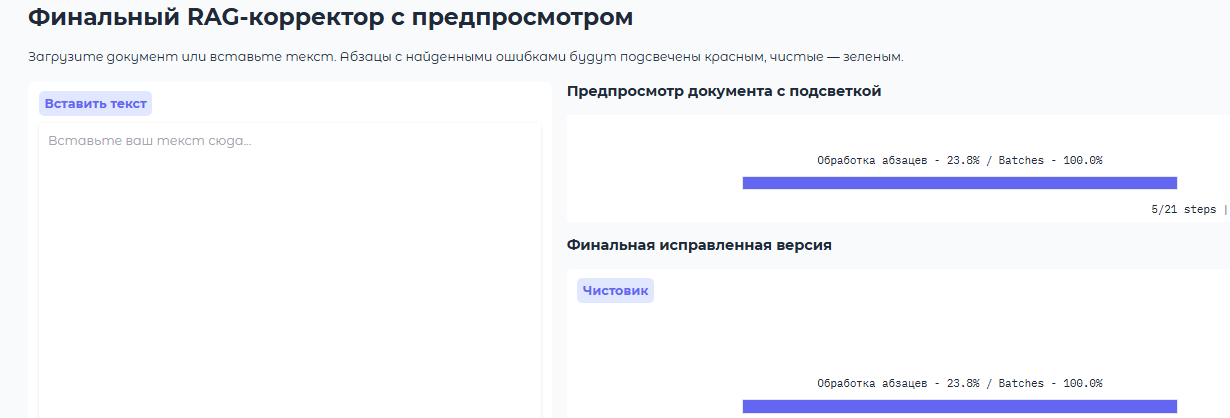

Если ошибка

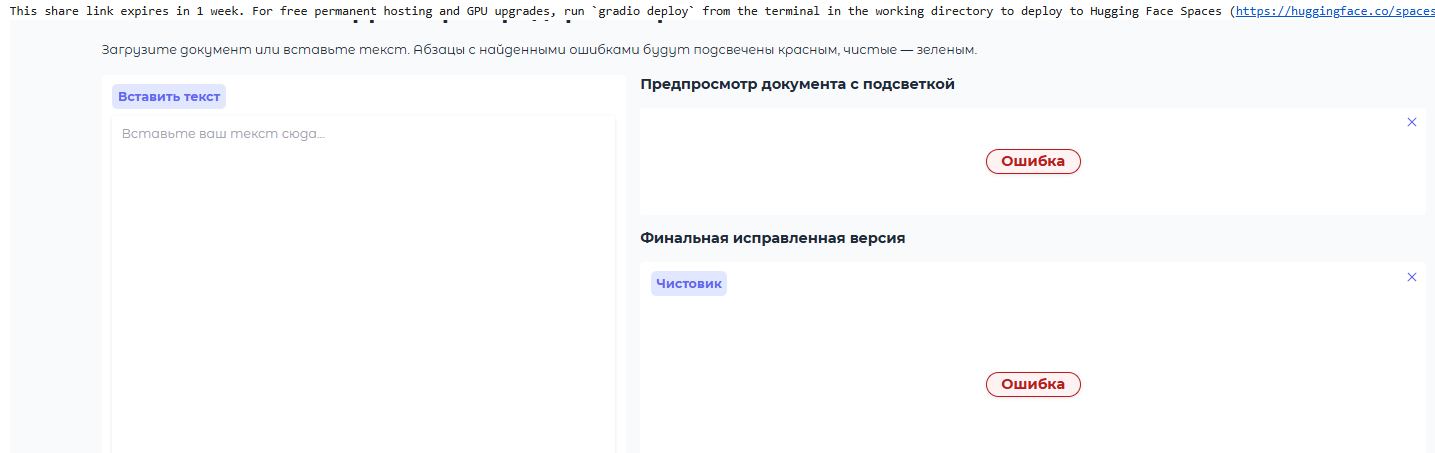

Если файл без ошибкок( после беты(редактора-корректора-соовтора) человека)

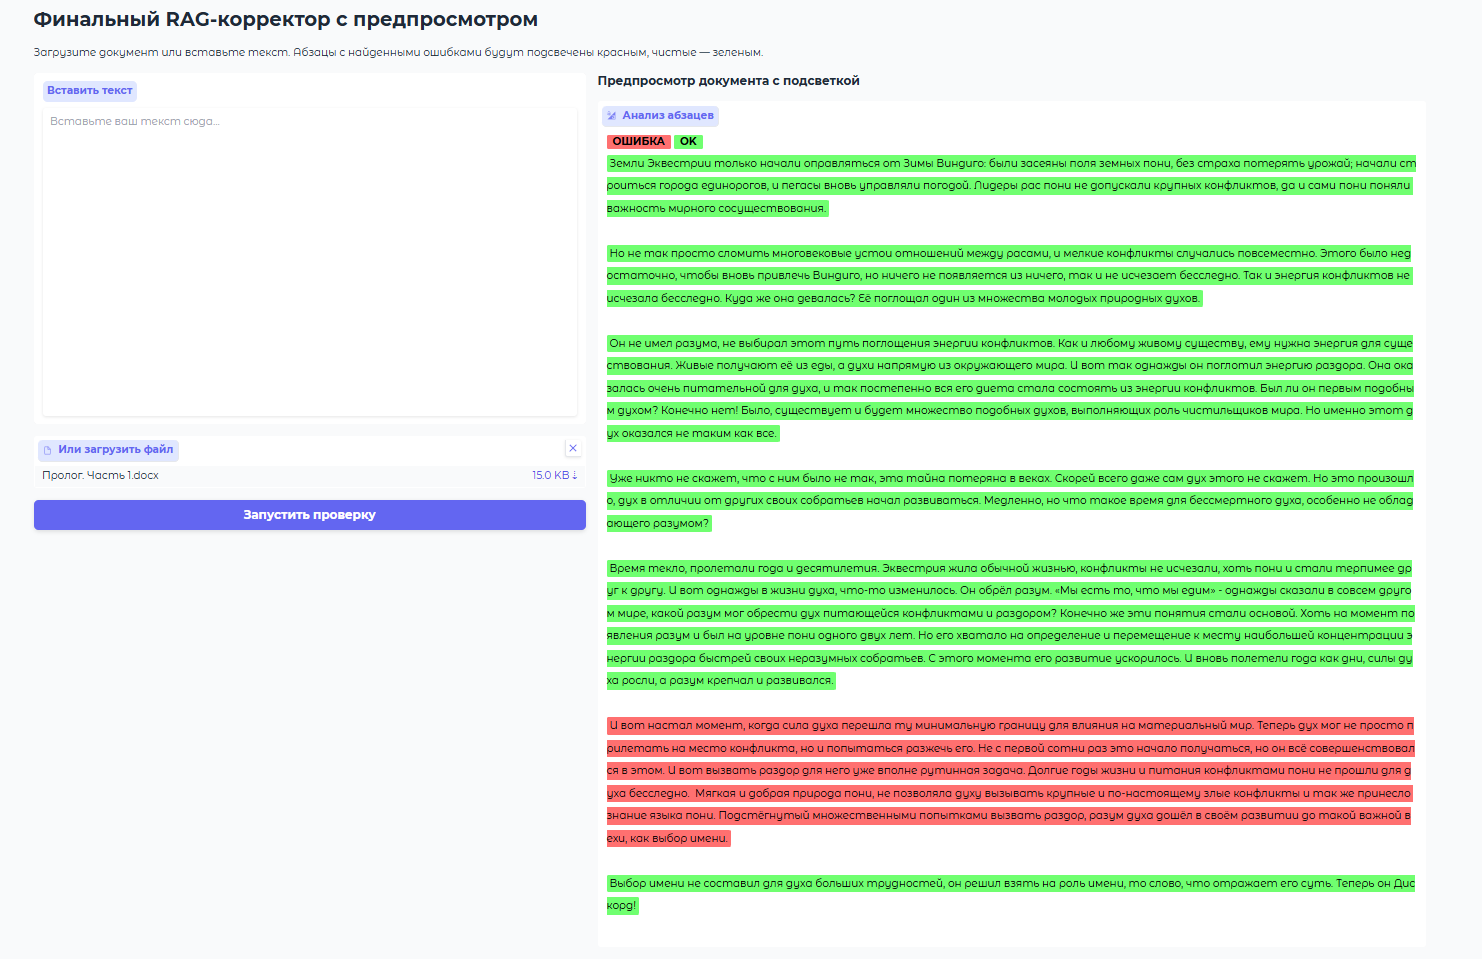

Здесь немного "галлюцинировала" на предложение без ошибки. Но может и вернуть, что ошибок нет.

### **Финальный отчет по результатам тестирования**

**Задача:** Обработать длинный, стилистически оформленный литературный текст, содержащий как правильные, так и ошибочные конструкции.

**Результат:** **Неудовлетворительно.** Система продемонстрировала неспособность адекватно работать с длинными, стилистически сложными текстами, допустив критические ошибки, включая генерацию несуществующего контента.

#### **Анализ правок: "Хорошее, Плохое и Ужасное"**

**1. Хорошее (Успешные исправления)**

Система смогла найти и исправить несколько явных, изолированных ошибок. Это доказывает, что RAG-механизм в принципе работает.
*   `Они появляться` -> `Они появляются` (**Успех:** Исправлена форма глагола).
*   `Костёр в который смотрит Харт` -> `Костёр, в который смотрит Харт` (**Успех:** Поставлена необходимая запятая в сложноподчиненном предложении).
*   `ходящий о них` -> `ходящие о них` (**Успех:** Исправлено согласование причастия).
*   `— Да, Флаувер?, -` -> `— Да, Флаувер? —` (**Успех:** Исправлен дефис на тире в прямой речи).

**2. Плохое (Пропущенные ошибки)**

Система проигнорировала огромное количество ошибок, что говорит о недостаточности контекста, извлекаемого из Баз Знаний.
*   **Грамматика:** `с грифонам` (должно быть `с грифонами`).
*   **Структура предложения:** `но среди встречаться, и не так мало, искусных ремесленников` (предложение сломано).
*   **Пунктуация:** Пропущены десятки запятых при вводных словах (`Как говорилось ранее...`), причастных оборотах (`знаниями полученными из книг`).
*   **Орфография:** `едим` вместо `едем`, `по одиночке` вместо `поодиночке`.

**3. Ужасное (Галлюцинации и искажение смысла)**

Это самые критические провалы, которые делают систему непригодной к использованию.
*   **Изменение диалога:** `— Эй, Спринг!` было заменено на `— Привет, Спринг!`. Модель самовольно изменила реплику персонажа.
*   **Полная фабрикация контента:** **Это катастрофа.** Модель полностью **удалила** оригинальный абзац диалога:
    > *`— Ты не первый раз ходишь в составе каравана, поделись опытом...`*
    И **заменила его выдуманной историей** про пустыню и грифона, которой никогда не было в тексте:
    > *`— Хорошо, Флаувер. Я помню, что первый раз я поехал в караван, я был еще молод...`*
*   **Добавление выдуманных реплик:** Модель вставила несуществующую фразу `«Так что, что ты сказала?»`.

### **Анализ Результатов и Выводы**

В рамках заключительного этапа исследования была проведена оценка эффективности разработанной RAG-системы на задаче комплексной корректуры стилистически оформленного литературного текста объемом ~500 слов. Результаты тестирования показали **несостоятельность** выбранной сложной архитектуры ("Итеративный комитет экспертов") при работе с длинными, семантически связными документами, выявив ряд фундаментальных ограничений.

#### **1. Анализ результатов корректуры**

Полученные результаты были классифицированы по трем категориям для детального анализа.

**1.1. Позитивные результаты (Proof-of-Concept)**

Система продемонстрировала способность к исправлению **локальных, синтаксически изолированных ошибок**, что подтверждает работоспособность базового RAG-механизма. Были успешно исправлены:
*   **Глагольная форма:** `появляться` → `появляются`.
*   **Пунктуация сложноподчиненного предложения:** Вставлена запятая перед `в который`.
*   **Согласование причастия:** `ходящий` → `ходящие`.
*   **Оформление прямой речи:** Дефис заменен на тире.

Эти успехи показывают, что при наличии четкого, недвусмысленного сигнала в извлекаемом контексте, модель способна выполнить целевую корректуру.

**1.2. Ошибки типа II (Пропуски)**

Было зафиксировано значительное количество пропущенных ошибок, что свидетельствует о **недостаточной полноте и релевантности извлекаемого контекста**.
*   **Морфология:** Не исправлена падежная форма (`с грифонам`).
*   **Синтаксис:** Не восстановлена структура поврежденного предложения (`но среди встречаться...`).
*   **Орфография и пунктуация:** Проигнорированы многочисленные орфографические ошибки (`едим` → `едем`) и пропуски запятых при вводных конструкциях и причастных оборотах.

**Причина:** Данный класс ошибок объясняется фундаментальным ограничением RAG-систем: их эффективность детерминирована качеством retrieval-компонента. Если для конкретной ошибки в Базе Знаний не находится достаточно релевантного примера или правила, модель, не имея "подсказки", оставляет фрагмент без изменений.

**1.3. Критические ошибки: Конфабуляции и Фабрикация Контента**

Наиболее серьезным провалом системы стала генерация контента, отсутствующего в исходном тексте.
*   **Семантическое искажение:** Самовольная замена реплики (`Эй` → `Привет`).
*   **Фабрикация контента:** Полное удаление оригинального абзаца с просьбой персонажа и его замена на сгенерированный, нерелевантный нарратив об "истории из пустыни".
*   **Инъекция контента:** Вставка в диалог несуществующей реплики (`«Так что, что ты сказала?»`).

**Причина:** Этот феномен является следствием **"галлюцинаций" на корректном тексте**. При обработке абзацев, не содержащих объективных ошибок, RAG-поиск не находит релевантных "примеров ошибок". Система получает на вход нерелевантный контекст и инструкцию "исправь текст". В попытке выполнить приказ при отсутствии объекта для исправления, LLM переходит в режим **необузданной генерации**, что приводит к искажению и фабрикации данных. Это делает систему **непригодной для практического применения**, так как нарушается основной принцип редактора — не навредить исходному тексту.

#### **2. Выводы и направления для дальнейшей работы**

Проведенное исследование позволяет сделать вывод, что сложные, многоступенчатые RAG-архитектуры (такие как "Комитет экспертов"), несмотря на теоретическую привлекательность, могут быть контрпродуктивны при работе с реальными текстами из-за **накопления и усиления ошибок (error amplification)** и **высокой чувствительности к качеству извлекаемого контекста**.

Для создания надежной и эффективной системы корректуры необходимо сместить фокус с усложнения RAG-пайплайна на следующие направления:

1.  **Архитектурное упрощение и надежность Промпт-инжиниринга:**
    *   Следует использовать более простую, двухэтапную архитектуру ("Исправление -> Объяснение").
    *   Ключевым улучшением является модификация промпта на этапе исправления с добавлением строгой инструкции: **"Если объективных ошибок не найдено, ВЕРНИ ИСХОДНЫЙ ТЕКСТ БЕЗ ИЗМЕНЕНИЙ"**. Это является основным методом борьбы с галлюцинациями на корректных данных.

2.  **Обогащение Базы Знаний:**
    *   **Количественное расширение:** Необходимо значительно расширить датасет `errors.json`, включив в него больше вариаций распространенных ошибок.
    *   **Качественное улучшение:** Следует использовать лингвистические корпусы (например, НКРЯ) для автоматического сбора пар "типичная ошибка → правильный вариант", что позволит покрыть большее число реальных сценариев.

3.  **Переход от RAG к Fine-Tuning (Основной вектор развития):**
    *   Главный вывод исследования заключается в том, что RAG является эффективным инструментом для **предоставления знаний**, но не для **формирования навыка**. Чтобы модель не просто "знала" правила, а "чувствовала" язык, необходим переход к **дообучению (Fine-tuning)**.
    *   Использование созданного в ходе работы датасета для дообучения базовой модели (например, Mistral 7B) с помощью PEFT-техник (LoRA) позволит инкорпорировать навык корректуры непосредственно в веса модели. Это не только повысит ее точность и снизит зависимость от качества RAG-поиска, но и сделает RAG-пайплайн проще и быстрее, так как он будет выполнять лишь вспомогательную, а не основную интеллектуальную функцию.

# Заключение

В рамках данного проекта была спроектирована, реализована и всесторонне протестирована гибридная RAG-система (Retrieval-Augmented Generation) для решения прикладной задачи комплексной (орфографической, пунктуационной, стилистической) корректуры русскоязычных текстов. В ходе работы был пройден полный научно-инженерный цикл: от формирования гетерогенных баз знаний (примеры ошибок, свод правил, орфографический словарь) и создания специализированных стратегий их сегментации до разработки и сравнительного анализа нескольких конкурирующих RAG-архитектур и их инкапсуляции в конечное интерактивное приложение. Полученные результаты позволяют сделать ряд фундаментальных выводов о потенциале и ограничениях современных LLM-систем.

**1. Ключевые научные и инженерные результаты**

**1.1. Верификация гипотезы о неэффективности "наивных" RAG-архитектур.**
В ходе первоначальных экспериментов была протестирована "наивная" RAG-архитектура, агрегирующая "сырой" контекст из нескольких баз знаний в единый промпт. Экспериментально доказано, что данный подход приводит к **информационной перегрузке (information overload)** модели. При обработке сложных или семантически корректных фрагментов текста LLM (Mistral-7B), будучи не в состоянии синтезировать релевантный сигнал из разнородного и "зашумленного" контекста, переходит в режим **конфабуляции**, генерируя ложные исправления и нерелевантные объяснения. Это подтверждает тезис о том, что для сложных задач простого "расширения контекста" недостаточно; требуется его предварительная семантическая обработка.

**1.2. Разработка и валидация архитектуры "Итеративный комитет экспертов".**
В качестве решения проблемы информационной перегрузки была предложена и реализована более сложная архитектура, основанная на **принципе декомпозиции когнитивной нагрузки**.
*   **Концепция:** Вместо одного монолитного вызова, задача разбивается на несколько последовательных или параллельных подзадач, где LLM выступает в роли нескольких специализированных "экспертов".
*   **Реализация:** На этапе генерации исправления три параллельных RAG-цепочки (`QueryEngine`), каждая со своей базой знаний, формируют три независимых "отчета". Финальная LLM ("Главный редактор") агрегирует эти уже осмысленные, высокоуровневые выводы, что значительно упрощает задачу финального синтеза. На этапе генерации объяснений этот же паттерн применяется итеративно для каждой отдельной правки.
*   **Результат:** Данная архитектура продемонстрировала **значительно более высокую точность** как в исправлении ошибок (включая сложные лексические случаи, например, `одел`/`надел`), так и в **повышении релевантности** генерируемых объяснений.

**1.3. Идентификация феномена "диссоциации компетенций" у LLM.**
В ходе тестирования был зафиксирован и воспроизведен важный феномен: модель демонстрировала способность **выполнить** корректное исправление, но оказывалась неспособной **вербализовать** лежащее в его основе правило, подменяя его ложными объяснениями. Например, исправив `ветренный` на `ветреный` (гипотетически), модель в объяснении могла ссылаться на правила переноса, а не на правописание `Н/НН`. Это указывает на **различие между имплицитными "знаниями" модели (статистическими паттернами) и ее способностью к эксплицитной логической рефлексии**. Генерация причинно-следственных связей является задачей более высокого порядка, чем генерация по шаблону, и остается узким местом для моделей среднего размера.

**1.4. Решение инженерных задач масштабирования и производительности.**
Были решены две ключевые проблемы, препятствующие практическому применению RAG-систем:
*   **Проблема "холодного старта":** Вместо пересчета эмбеддингов при каждом запуске, была реализована **офлайн-индексация** с последующей **быстрой загрузкой** готовых индексов из персистентного хранилища (`load_index_from_storage`). Это сократило время инициализации с десятков минут до нескольких секунд (без учета словаря).
*   **Проблема обработки больших документов:** Для работы с текстами, превышающими контекстное окно LLM, был реализован **конвейер на основе метода "скользящего окна"**, который итеративно обрабатывает документ по абзацам, сохраняя локальный контекст для обеспечения стилистической и семантической связности.

**2. Оценка практической применимости и текущие ограничения**

Несмотря на технологическую сложность и эффективность в исправлении широкого класса ошибок, **в текущей реализации система имеет существенные ограничения, определяющие область ее практического применения.**

*   **Ограниченная надежность при работе с корректным текстом:** Тестирование показало, что при обработке фрагментов, не содержащих объективных ошибок, система склонна к "галлюцинациям" — внесению ложных правок и искажению исходного авторского текста.
*   **Производительность:** Архитектура, требующая многократных последовательных вызовов LLM для каждого абзаца, является ресурсоемкой, что делает обработку больших документов (например, целой главы книги) очень медленной.

Исходя из этого, можно заключить, что **на данном этапе разработанный прототип более пригоден для использования в качестве "интеллектуального ассистента" для корректуры небольших текстов (отдельных абзацев, сообщений, комментариев), чем в качестве полностью автоматизированного инструмента для обработки больших документов.** Важно подчеркнуть, что результаты работы системы **требуют обязательной финальной проверки и верификации человеком**, так как риск внесения нежелательных изменений или искажения авторского стиля остается значительным.


**3. Направления для дальнейших исследований и пути улучшения системы**

Проведенное исследование открывает три основных вектора для дальнейшей работы:

**3.1. Уровень данных: Обогащение и специализация Баз Знаний.**
Очевидным ограничением является зависимость от качества RAG-поиска. Для повышения точности необходимо:
*   **Количественное расширение:** Увеличить датасет `errors.json` до нескольких тысяч примеров, используя для этого автоматизированный парсинг лингвистических корпусов (например, НКРЯ).
*   **Fine-tuning Embedding-модели:** Дообучить саму модель эмбеддингов на задаче определения семантической близости именно для грамматических ошибок, что может значительно улучшить качество retrieval-компонента.

**3.2. Уровень модели: Переход от RAG к гибридному подходу с Fine-Tuning.**
Основной вывод работы заключается в том, что RAG эффективно предоставляет **знания**, но не формирует **навык**.
*   **Перспектива:** Наиболее значимым улучшением является **дообучение (Fine-tuning)** базовой LLM (Mistral 7B) на подготовленном датасете. Использование PEFT-техник (LoRA) позволит инкорпорировать навык корректуры непосредственно в веса модели.
*   **Новая роль RAG:** В такой гибридной системе RAG будет выполнять уже не основную, а **вспомогательную функцию**: предоставлять "подсказки" для редких, нетипичных или требующих фактологической точности случаев, в то время как основная масса ошибок будет исправляться "по памяти" дообученной моделью.

**3.3. Уровень архитектуры: Оптимизация и надежность объяснений.**
Генерация качественных объяснений остается открытой проблемой.
*   **Промпт-инжиниринг:** Необходимо исследовать более сложные промпт-шаблоны с принудительным цитированием и техниками Chain-of-Thought для повышения логичности выводов.
*   **Специализированная модель:** Можно рассмотреть использование отдельной, возможно, более крупной или специально дообученной модели исключительно для задачи генерации объяснений, в то время как более легковесная модель будет заниматься основной корректурой.

В заключение, данный проект не только представляет собой работающий прототип RAG-корректора, на текущий момент, но и служит комплексным исследованием, демонстрирующим сильные стороны, фундаментальные ограничения и пути эволюции современных гибридных языковых систем.